# 读取数据

In [60]:
import pickle
road_zip={}
orthogonal_list={}
pointers={}
node_dict={}
node_dict_amap={}
way_list=[]
with open('road_zip.pkl','rb') as f:
    road_zip=pickle.load(f)
with open('map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('graph.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('graph_pointers.pkl','rb') as f:
    pointers=pickle.load(f)
with open('map_ways.pkl','rb') as f:
    way_list=pickle.load(f)

# 将高德路段与拓扑图对应

In [61]:
#从道路方向信息中解析出道路的起讫点
def decodeDirection(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end
def findRelatedEdges(name,s,d):
    sv_list,dv_list=[],[]
    for vertex in way_vertex_dict[name]:
        in_list=[edge[0] for edge in orthogonal_list[vertex][0]]
        out_list=[edge[0] for edge in orthogonal_list[vertex][1]]
        if s in in_list or s in out_list:
            sv_list.append(vertex)
        if d in in_list or d in out_list:
            dv_list.append(vertex)

    related_edges=[]
    #能找到起讫点
    if len(sv_list)>0 and len(dv_list)>0:
        route=[]
        for s in sv_list:
            history_v=[s]
            answer_v=[]
            next_seq=[[s]]
            while len(next_seq)>0:
                seq=next_seq.pop()
                v=seq[-1]
                edge=orthogonal_list[v][0]+orthogonal_list[v][1]
                for e in edge:
                    if e[0]==name and e[1] not in history_v:
                        history_v.append(e[1])
                        if e[1] in dv_list:
                            answer_v.append(seq+[e[1]])
                        else:
                            next_seq.append(seq+[e[1]])
            route.extend(answer_v)
        if len(route)==0:
            print(name,s,d,'error:有起讫点但找不到路径')
        for rt in route:
            for i in range(1,len(rt)):
                a,b=rt[i-1],rt[i]
                is_find=False
                v,no='',0
                for i,e in enumerate(orthogonal_list[a][1]):
                    if e[0]==name and e[1]==b:
                        is_find=True
                        v=a
                        no=i
                        break
                if not is_find:
                    for i,e in enumerate(orthogonal_list[b][1]):
                        if e[0]==name and e[1]==a:
                            is_find=True
                            v=b
                            no=i
                            break
                if not is_find:
                    print('err')
                elif (v,no) not in related_edges:
                    related_edges.append((v,no))
    #找不到起讫点，则将所有路段纳入相关边
    else:
#         for p in pointers[name]:
#             if p[0]==begin or p[0]==end or p[1]==begin or p[1]==end:
#                 related_edges.append((p[2],p[3]))
        for v in way_vertex_dict[name]:
            for no,e in enumerate(orthogonal_list[v][1]):
                if e[0]==name:
                    related_edges.append((v,no))
        if len(related_edges)==0:
            print('error')
    return related_edges

In [62]:
from copy import deepcopy
way_vertex_list=[]
for way in way_list:
    vertex_list=[]
    for node in way[1]:
        if node in orthogonal_list:
            vertex_list.append(node)
    if len(vertex_list)>0:
        way_vertex_list.append((way[0],vertex_list))
way_vertex_dict={}
for way in way_vertex_list:
    if way[0] not in way_vertex_dict:
        way_vertex_dict[way[0]]=way[1]
    else:
        way_vertex_dict[way[0]].extend(way[1])
for way in way_vertex_dict:
    way_vertex_dict[way]=list(set(way_vertex_dict[way]))

keys=list(road_zip.keys())
road_edges={}
for road in keys:
    if road[0] in way_vertex_dict:
        begin,end=decodeDirection(road[1])
        related_edges=findRelatedEdges(road[0],begin,end)
        if len(related_edges)>0:
            road_edges[road]=related_edges
'''
spatial_maps:
              in_edges               || vnode ||              out_edges
[(roadname,sv)|(road_name,sv,road)]  ||   v   || [(road_name,dv)|(road_name,dv,road)]
'''
spatial_maps=deepcopy(orthogonal_list)
for road,edges in road_edges.items():
    for edge in edges:
        v,oute=edge[0],edge[1]
        rname=spatial_maps[v][1][oute][0]
        dv=spatial_maps[v][1][oute][1]
        spatial_maps[v][1][oute].append(road)
        for i in range(len(spatial_maps[dv][0])):
            if spatial_maps[dv][0][i][0]==rname:
                spatial_maps[dv][0][i].append(road)

通耀路 1802993396 世博馆路 error:有起讫点但找不到路径
通耀路 618841675 耀龙路 error:有起讫点但找不到路径
齐河路 1893030113 云台路 error:有起讫点但找不到路径
北艾路 603172147 高科西路 error:有起讫点但找不到路径
北艾路 747585384 杨高南路 error:有起讫点但找不到路径
双桥路 614397678 张杨北路 error:有起讫点但找不到路径
芙蓉江路 560440805 长宁路 error:有起讫点但找不到路径
芙蓉江路 560396863 虹古路 error:有起讫点但找不到路径
同普路 3001826704 中江路 error:有起讫点但找不到路径
梅川路 1078518665 兰溪路 error:有起讫点但找不到路径
丰庄路 3001827460 曹安公路 error:有起讫点但找不到路径
丰庄路 499159062 金沙江路 error:有起讫点但找不到路径
国权路 558624902 四平路 error:有起讫点但找不到路径
政民路 475384381 淞沪路 error:有起讫点但找不到路径
政民路 600512526 武东路 error:有起讫点但找不到路径
武川路 858662770 政立路 error:有起讫点但找不到路径
武川路 7190124003 纪念路 error:有起讫点但找不到路径
江场路 2477940109 粤秀路 error:有起讫点但找不到路径
江场路 477436679 奎照路 error:有起讫点但找不到路径
虬江路 266082085 四川北路 error:有起讫点但找不到路径
武胜路 476675200 西藏中路 error:有起讫点但找不到路径
银城中路 602360634 东昌路 error:有起讫点但找不到路径
福建北路 477642555 海宁路 error:有起讫点但找不到路径
福建北路 479914787 福建中路 error:有起讫点但找不到路径
天潼路 267198579 大名路 error:有起讫点但找不到路径
东汉阳路 475861594 新建路 error:有起讫点但找不到路径
东汉阳路 475861917 溧阳路 error:有起讫点但找不到路径
武定路 554132715 武宁南路 error:有起讫点但找不

In [63]:
import pickle
with open('road_edges.pkl','wb') as f:
    pickle.dump(road_edges,f)

In [64]:
import numpy as np
node_id2no={Id:No for No,Id in enumerate(orthogonal_list)}
matrix=[[0 for _ in range(len(orthogonal_list))] for _ in range(len(orthogonal_list))]
for v,e in orthogonal_list.items():
    for eout in e[1]:
        matrix[node_id2no[v]][node_id2no[eout[1]]]=1
        matrix[node_id2no[eout[1]]][node_id2no[v]]=1
        
import cv2 as cv
sample=np.array(matrix)
image=255*sample
cv.imwrite("graph_martix.png", image)

True

绘制匹配路段图

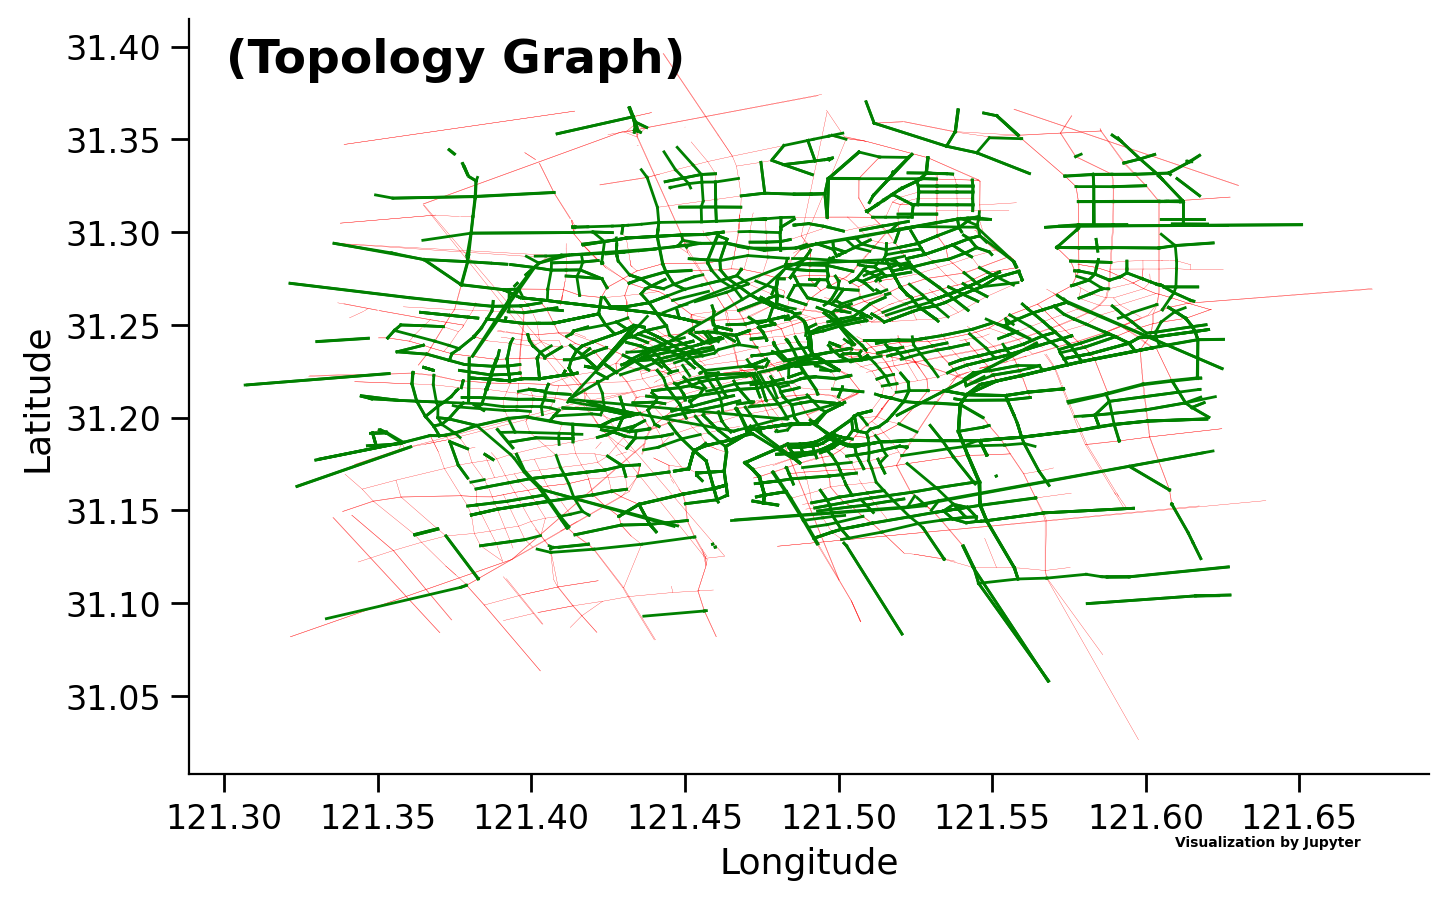

In [65]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='r',linewidth=.1)
for road,edges in road_edges.items():
    for edge in edges:
        a=edge[0]
        b=orthogonal_list[a][1][edge[1]][1]
        ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='g',linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Topology Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()

# 模式挖掘

In [4]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
data=data.swapaxes(0,1)#date,road,time,regular_speed
data=np.concatenate(data,axis=1)#road,datetime,regular_speed
data=data.T#datetime,road,regular_speed
adj_matrix=[[0 for j in range(len(road_zip))] for i in range(len(road_zip))]
k=5    #k代表检查当前时间点之前kT范围内所有产生拥堵的路段
g=3    #g代表将当前道路的g阶邻居纳入检查范围
old_cjst_group=[[] for _ in range(k)]    #前kT时间段内曾经发生拥堵的道路集合，每个T各成一个列表
new_cjst=[]    #记录当前时间内发生拥堵的路段
#按照时间遍历
for Tdata in data:
    new_cjst=[]    #清空新拥堵道路集合
    old_cjst=[]    #构建历史拥堵道路集合
    for cjst in old_cjst_group:
        old_cjst.extend(cjst)
    #按照道路遍历
    for i,Rdata in enumerate(Tdata):
        #如果道路发生了拥堵
        if Rdata<=0.5 and Rdata!=0.0:
            road=list(road_zip.keys())[i]
            #将道路的对应矩阵的值增加
            adj_matrix[i][i]+=1
            #如果道路拥堵是新发生的
            if road not in old_cjst:
                #通过广度优先遍历当前道路的g阶邻居道路并筛选出曾经拥堵的g阶邻居
                roads_stack=[road]
                adj_roads=[]
                for _ in range(g):
                    new_roads_stack=[]
                    while len(roads_stack)>0:
                        current=roads_stack.pop()
                        if current not in road_edges:
                            continue
                        for edge in road_edges[current]:
                            s=edge[0]
                            d=spatial_maps[s][1][edge[1]][1]
                            for e in spatial_maps[s][0]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[s][1]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[d][0]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                            for e in spatial_maps[d][1]:
                                if len(e)>2 and e[2]!=current and e[2] not in adj_roads and e[2] in old_cjst:
                                    adj_roads.append(e[2])
                                    new_roads_stack.append(e[2])
                    roads_stack=new_roads_stack
                #每一个曾经拥堵的祖先道路都对当前道路施加影响，将对应的矩阵的边的值增加
                for adj in adj_roads:
                    adj_matrix[list(road_zip.keys()).index(adj)][i]+=1
            new_cjst.append(road)
    #更新历史拥堵道路
    for i in range(1,k):
        old_cjst_group[i-1]=old_cjst_group[i]
    old_cjst_group[k-1]=new_cjst
#绘制矩阵
import cv2 as cv
sample=np.array(adj_matrix)
sample=np.int64(sample>0)
sample=255.0*sample
cv.imwrite("adj_matrix.png", sample)

True

48


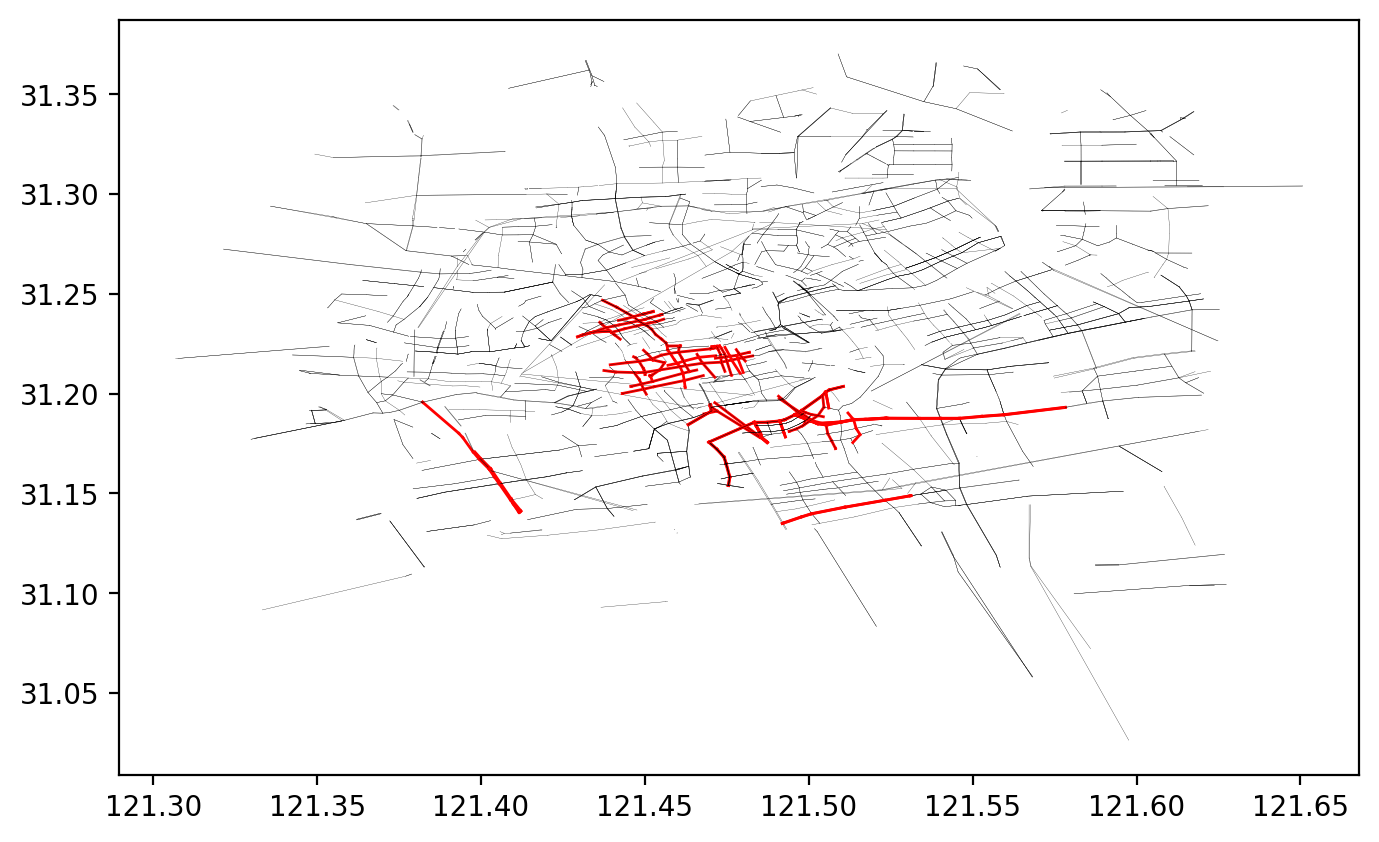

In [20]:
import matplotlib.pyplot as plt
critical_road=[]
for i in range(len(adj_matrix)):
    if np.sum(adj_matrix[i])-adj_matrix[i][i]>2500:
        critical_road.append(list(road_zip.keys())[i])
print(len(critical_road))
ref=node_dict_amap
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
for road in road_zip.keys():
    if road not in road_edges:
        continue
    for edge in road_edges[road]:
        a=edge[0]
        b=orthogonal_list[a][1][edge[1]][1]
        if road in critical_road:
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='red',linewidth=1)
        else:
            ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color='black',linewidth=.1)
fig.show()

# 事件挖掘

In [66]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,:]#road,date,time,[status, regular_speed]
data=data.reshape((-1,2))#[status, regular_speed]
status1=np.array([item[1] for item in data if item[0]==1])
status2=np.array([item[1] for item in data if item[0]==2])
print(len(status1),len(status2))

3630424 63099


In [67]:
speed_threshold=0.0
step=0.01
for _ in range(1000):
    rate1=np.sum(status1>speed_threshold)/len(status1)
    rate2=np.sum(status2<speed_threshold)/len(status2)
    if rate1>rate2:
        speed_threshold+=step
    elif rate1<rate2:
        speed_threshold-=step
print(speed_threshold)

0.5000000000000002


In [78]:
import numpy as np
data=np.array(list(road_zip.values()))[:,:,:,1]#road,date,time,regular_speed
cjstT=0.5
g=1
root_cjst=[]
for date in range(data.shape[1]):
    for time in range(1,data.shape[2]):
        for rid in range(data.shape[0]):
            if 0<data[rid][date][time]<cjstT:
                road=list(road_zip.keys())[rid]
                if road not in road_edges:
                    continue
                is_root=True
                stack=[]
                if len(road_edges[road])==0:
                    print('error: 存在len(road_edges[road])==0')
                for edge in road_edges[road]:
                    s=edge[0]
                    d=spatial_maps[s][1][edge[1]][1]
                    stack.append(s)
                    stack.append(d)
                history=[]
                #通过广度优先遍历当前道路的g阶邻居道路
                for _ in range(g):
                    new_stack=[]
                    while len(stack)>0 and is_root:
                        v=stack.pop()
                        if v in history:
                            continue
                        else:
                            history.append(v)
                            checked_edges=spatial_maps[v][0]+spatial_maps[v][1]
                            for e in checked_edges:
                                if len(e)>2 and e[2]!=road and 0<road_zip[e[2]][date][time-1][1]<cjstT:
                                    is_root=False
                                    break
                                new_stack.append(e[1])
                    stack=new_stack
                    if not is_root:
                        break
                if is_root:
                    root_cjst.append({'date':date,'time':time,'rid':rid})
    # break

In [79]:
from copy import deepcopy
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

class event:
    def __init__(self):
        self.date=0        # 事件发生日期
        self.start_time=0  # 事件开始时间
        self.end_time=0    # 事件结束时间
        self.cjst_seq=[]   # 时间过程，{时间, 拥堵路段列表}
cjstT=0.5
cjst_events=[]
bar = ProgressBar(widgets=widgets, maxval=len(root_cjst)).start()
# 遍历每一个拥堵事件源
for i,root in enumerate(root_cjst):
    # 如果该拥堵事件源在早些时刻已经被记录则直接跳过
    if {'date':root['date'],'time':root['time']-1,'rid':root['rid']} in root_cjst:
        continue
    # 初始化拥堵事件
    new_event=event()
    new_event.date=root['date']
    new_event.start_time=root['time']
    new_event.cjst_seq.append({'time':root['time'],'rids':[root['rid']]})
    # 从拥堵事件的起始时间开始向后推演
    former_edge=[]
    for time in range(new_event.start_time+1,data.shape[2]):
        old_snapshot=new_event.cjst_seq[-1]
        new_snapshot={'time':time,'rids':[]}
        # 考察上一个快照，将拥堵持续到当前的路段加入当前快照
        for rid in old_snapshot['rids']:
            if 0<data[rid][new_event.date][time]<cjstT:
                new_snapshot['rids'].append(rid)
                
        # 考察上一快照通过无信息路段传播的拥堵
        for e in former_edge:
            # 如果节点所连接的路段发生了拥堵，则加入到当前的拥堵快照中
            if len(e)>2 and 0<road_zip[e[2]][new_event.date][time][1]<cjstT:
                new_snapshot['rids'].append(list(road_zip.keys()).index(e[2]))
        former_edge=[]
        
        # 上一快照的所有路段都有传播拥堵的可能系，因此将上一快照的所有节点纳入stack
        history=[]
        stack=[]
        for rid in old_snapshot['rids']:
            road=list(road_zip.keys())[rid]
            for edge in road_edges[road]:
                s=edge[0]
                d=spatial_maps[s][1][edge[1]][1]
                stack.append(s)
                stack.append(d) 
        stack=set(list(stack)) # 去重
        while len(stack)>0:
            v=stack.pop()
            if v in history:
                continue
            else:
                history.append(v)
                checked_edges=spatial_maps[v][0]+spatial_maps[v][1]
                for e in checked_edges:
                    # 如果节点所连接的路段发生了拥堵，则加入到当前的拥堵快照中
                    if len(e)>2 and 0<road_zip[e[2]][new_event.date][time][1]<cjstT:
                        new_snapshot['rids'].append(list(road_zip.keys()).index(e[2]))
                    # 如果这个路段没有路况信息，则考虑路段的另一个端点
                    elif len(e)<=2:
                        second_edges=spatial_maps[e[1]][0]+spatial_maps[e[1]][1]
                        for se in second_edges:
                            if se not in former_edge:
                                former_edge.append(e)
        new_snapshot['rids']=list(set(new_snapshot['rids'])) # 去重
        if len(new_snapshot['rids'])>0:
            new_event.cjst_seq.append(new_snapshot)
        else:
            new_event.end_time=time
            break
    bar.update(i+1)
    if new_event.end_time==0 or new_event.end_time-new_event.start_time>24:
        new_event.end_time=data.shape[2]
        continue
    for snapshot in new_event.cjst_seq:
        if len(snapshot['rids'])>1:
            cjst_events.append(new_event)
            break
bar.finish()

Progress: 100% |##############| Elapsed Time: 1:14:37 Time: 1:14:37  51.11  B/s


## OVERVIEW

In [80]:
# overview
print('total number of events is:',len(cjst_events))
count=0
for no,event in enumerate(cjst_events):
    print('no:',no,'date: 10-',2+event.date,'len:',5*(event.end_time-event.start_time),'start time:',5+5*event.start_time//60,':',5*event.start_time%60,'end time:',5+5*event.end_time//60,':',5*event.end_time%60)
    for shot in event.cjst_seq:
        print(len(shot['rids']),end='')
    print("\n")
    count+=1
print(count)
    

total number of events is: 14355
no: 0 date: 10- 2 len: 20 start time: 5 : 5 end time: 5 : 25
1211

no: 1 date: 10- 2 len: 35 start time: 5 : 5 end time: 5 : 40
1121211

no: 2 date: 10- 2 len: 45 start time: 5 : 5 end time: 5 : 50
111122232

no: 3 date: 10- 2 len: 40 start time: 5 : 5 end time: 5 : 45
12221111

no: 4 date: 10- 2 len: 40 start time: 5 : 5 end time: 5 : 45
11212212

no: 5 date: 10- 2 len: 95 start time: 5 : 5 end time: 6 : 40
1221112122222212221

no: 6 date: 10- 2 len: 10 start time: 5 : 5 end time: 5 : 15
12

no: 7 date: 10- 2 len: 55 start time: 5 : 5 end time: 6 : 0
13122113311

no: 8 date: 10- 2 len: 45 start time: 5 : 5 end time: 5 : 50
112112232

no: 9 date: 10- 2 len: 15 start time: 5 : 5 end time: 5 : 20
112

no: 10 date: 10- 2 len: 15 start time: 5 : 10 end time: 5 : 25
121

no: 11 date: 10- 2 len: 15 start time: 5 : 10 end time: 5 : 25
112

no: 12 date: 10- 2 len: 40 start time: 5 : 10 end time: 5 : 50
11112232

no: 13 date: 10- 2 len: 50 start time: 5 : 10 end

112111111

no: 195 date: 10- 2 len: 10 start time: 8 : 0 end time: 8 : 10
12

no: 196 date: 10- 2 len: 20 start time: 8 : 0 end time: 8 : 20
1222

no: 197 date: 10- 2 len: 40 start time: 8 : 0 end time: 8 : 40
11211111

no: 198 date: 10- 2 len: 15 start time: 8 : 0 end time: 8 : 15
121

no: 199 date: 10- 2 len: 40 start time: 8 : 0 end time: 8 : 40
12211111

no: 200 date: 10- 2 len: 15 start time: 8 : 0 end time: 8 : 15
122

no: 201 date: 10- 2 len: 75 start time: 8 : 0 end time: 9 : 15
122211111111111

no: 202 date: 10- 2 len: 15 start time: 8 : 0 end time: 8 : 15
122

no: 203 date: 10- 2 len: 20 start time: 8 : 5 end time: 8 : 25
1131

no: 204 date: 10- 2 len: 75 start time: 8 : 5 end time: 9 : 20
121111111111111

no: 205 date: 10- 2 len: 20 start time: 8 : 5 end time: 8 : 25
1121

no: 206 date: 10- 2 len: 15 start time: 8 : 5 end time: 8 : 20
112

no: 207 date: 10- 2 len: 70 start time: 8 : 10 end time: 9 : 20
12111122212211

no: 208 date: 10- 2 len: 45 start time: 8 : 10 end time: 

no: 355 date: 10- 2 len: 75 start time: 11 : 5 end time: 12 : 20
111222221112121

no: 356 date: 10- 2 len: 50 start time: 11 : 5 end time: 11 : 55
1222222212

no: 357 date: 10- 2 len: 50 start time: 11 : 5 end time: 11 : 55
1222222212

no: 358 date: 10- 2 len: 110 start time: 11 : 10 end time: 13 : 0
1112111111111111111111

no: 359 date: 10- 2 len: 85 start time: 11 : 10 end time: 12 : 35
11121212211121122

no: 360 date: 10- 2 len: 65 start time: 11 : 15 end time: 12 : 20
1222221112121

no: 361 date: 10- 2 len: 35 start time: 11 : 15 end time: 11 : 50
1211111

no: 362 date: 10- 2 len: 40 start time: 11 : 15 end time: 11 : 55
12111111

no: 363 date: 10- 2 len: 40 start time: 11 : 15 end time: 11 : 55
12111111

no: 364 date: 10- 2 len: 10 start time: 11 : 15 end time: 11 : 25
12

no: 365 date: 10- 2 len: 25 start time: 11 : 20 end time: 11 : 45
12111

no: 366 date: 10- 2 len: 90 start time: 11 : 20 end time: 12 : 50
121111121111112111

no: 367 date: 10- 2 len: 40 start time: 11 : 20 end 

12111111111111111111111

no: 555 date: 10- 2 len: 55 start time: 16 : 0 end time: 16 : 55
12121111111

no: 556 date: 10- 2 len: 10 start time: 16 : 5 end time: 16 : 15
12

no: 557 date: 10- 2 len: 10 start time: 16 : 5 end time: 16 : 15
12

no: 558 date: 10- 2 len: 15 start time: 16 : 5 end time: 16 : 20
132

no: 559 date: 10- 2 len: 25 start time: 16 : 5 end time: 16 : 30
11212

no: 560 date: 10- 2 len: 25 start time: 16 : 5 end time: 16 : 30
11212

no: 561 date: 10- 2 len: 70 start time: 16 : 10 end time: 17 : 20
11111111112111

no: 562 date: 10- 2 len: 25 start time: 16 : 10 end time: 16 : 35
12211

no: 563 date: 10- 2 len: 35 start time: 16 : 10 end time: 16 : 45
1221221

no: 564 date: 10- 2 len: 85 start time: 16 : 10 end time: 17 : 35
11222211211222221

no: 565 date: 10- 2 len: 10 start time: 16 : 10 end time: 16 : 20
12

no: 566 date: 10- 2 len: 10 start time: 16 : 10 end time: 16 : 20
12

no: 567 date: 10- 2 len: 10 start time: 16 : 10 end time: 16 : 20
12

no: 568 date: 10- 2 

no: 730 date: 10- 2 len: 35 start time: 18 : 55 end time: 19 : 30
1212211

no: 731 date: 10- 2 len: 115 start time: 19 : 0 end time: 20 : 55
11211121212212211111211

no: 732 date: 10- 2 len: 10 start time: 19 : 0 end time: 19 : 10
12

no: 733 date: 10- 2 len: 20 start time: 19 : 0 end time: 19 : 20
1121

no: 734 date: 10- 2 len: 30 start time: 19 : 0 end time: 19 : 30
121111

no: 735 date: 10- 2 len: 110 start time: 19 : 0 end time: 20 : 50
1121222222222211211211

no: 736 date: 10- 2 len: 20 start time: 19 : 0 end time: 19 : 20
1121

no: 737 date: 10- 2 len: 70 start time: 19 : 0 end time: 20 : 10
12121222211222

no: 738 date: 10- 2 len: 85 start time: 19 : 5 end time: 20 : 30
11211111111111111

no: 739 date: 10- 2 len: 55 start time: 19 : 5 end time: 20 : 0
11111211111

no: 740 date: 10- 2 len: 80 start time: 19 : 5 end time: 20 : 25
1112111111111111

no: 741 date: 10- 2 len: 50 start time: 19 : 5 end time: 19 : 55
1222122221

no: 742 date: 10- 2 len: 10 start time: 19 : 5 end time: 1

12

no: 873 date: 10- 2 len: 15 start time: 21 : 50 end time: 22 : 5
112

no: 874 date: 10- 2 len: 65 start time: 21 : 55 end time: 23 : 0
1221221111221

no: 875 date: 10- 2 len: 85 start time: 21 : 55 end time: 23 : 20
12212221222212121

no: 876 date: 10- 2 len: 100 start time: 21 : 55 end time: 23 : 35
12234451113111133211

no: 877 date: 10- 2 len: 30 start time: 22 : 5 end time: 22 : 35
111121

no: 878 date: 10- 2 len: 20 start time: 22 : 5 end time: 22 : 25
1211

no: 879 date: 10- 2 len: 85 start time: 22 : 10 end time: 23 : 35
12231113111133211

no: 880 date: 10- 2 len: 15 start time: 22 : 10 end time: 22 : 25
121

no: 881 date: 10- 2 len: 15 start time: 22 : 15 end time: 22 : 30
121

no: 882 date: 10- 2 len: 45 start time: 22 : 15 end time: 23 : 0
121111221

no: 883 date: 10- 2 len: 65 start time: 22 : 15 end time: 23 : 20
1221222212121

no: 884 date: 10- 2 len: 25 start time: 22 : 20 end time: 22 : 45
11211

no: 885 date: 10- 2 len: 25 start time: 22 : 20 end time: 22 : 45
11122

no: 1007 date: 10- 3 len: 15 start time: 7 : 10 end time: 7 : 25
121

no: 1008 date: 10- 3 len: 20 start time: 7 : 10 end time: 7 : 30
1222

no: 1009 date: 10- 3 len: 55 start time: 7 : 10 end time: 8 : 5
11111112211

no: 1010 date: 10- 3 len: 10 start time: 7 : 10 end time: 7 : 20
12

no: 1011 date: 10- 3 len: 40 start time: 7 : 15 end time: 7 : 55
11131111

no: 1012 date: 10- 3 len: 65 start time: 7 : 20 end time: 8 : 25
1112111111121

no: 1013 date: 10- 3 len: 105 start time: 7 : 20 end time: 9 : 5
111111111111111111121

no: 1014 date: 10- 3 len: 20 start time: 7 : 20 end time: 7 : 40
1211

no: 1015 date: 10- 3 len: 65 start time: 7 : 20 end time: 8 : 25
1111122121222

no: 1016 date: 10- 3 len: 20 start time: 7 : 20 end time: 7 : 40
1211

no: 1017 date: 10- 3 len: 95 start time: 7 : 20 end time: 8 : 55
1221111111111111211

no: 1018 date: 10- 3 len: 60 start time: 7 : 25 end time: 8 : 25
111111111211

no: 1019 date: 10- 3 len: 55 start time: 7 : 25 end time: 8 : 20
11211111121

no: 1

no: 1130 date: 10- 3 len: 75 start time: 9 : 30 end time: 10 : 45
111122111333222

no: 1131 date: 10- 3 len: 30 start time: 9 : 35 end time: 10 : 5
121211

no: 1132 date: 10- 3 len: 95 start time: 9 : 35 end time: 11 : 10
1311213121111111121

no: 1133 date: 10- 3 len: 20 start time: 9 : 35 end time: 9 : 55
1121

no: 1134 date: 10- 3 len: 35 start time: 9 : 40 end time: 10 : 15
1211212

no: 1135 date: 10- 3 len: 45 start time: 9 : 40 end time: 10 : 25
111212221

no: 1136 date: 10- 3 len: 35 start time: 9 : 40 end time: 10 : 15
1212112

no: 1137 date: 10- 3 len: 80 start time: 9 : 45 end time: 11 : 5
1222211212122111

no: 1138 date: 10- 3 len: 10 start time: 9 : 45 end time: 9 : 55
12

no: 1139 date: 10- 3 len: 15 start time: 9 : 45 end time: 10 : 0
121

no: 1140 date: 10- 3 len: 30 start time: 9 : 45 end time: 10 : 15
112121

no: 1141 date: 10- 3 len: 80 start time: 9 : 50 end time: 11 : 10
1213121111111121

no: 1142 date: 10- 3 len: 35 start time: 9 : 50 end time: 10 : 25
1212221

no: 

1111211111111121111111

no: 1286 date: 10- 3 len: 60 start time: 13 : 50 end time: 14 : 50
122211212221

no: 1287 date: 10- 3 len: 40 start time: 13 : 50 end time: 14 : 30
12121111

no: 1288 date: 10- 3 len: 75 start time: 13 : 50 end time: 15 : 5
133322323332121

no: 1289 date: 10- 3 len: 85 start time: 13 : 50 end time: 15 : 15
12212221121212222

no: 1290 date: 10- 3 len: 60 start time: 13 : 55 end time: 14 : 55
111111121111

no: 1291 date: 10- 3 len: 50 start time: 13 : 55 end time: 14 : 45
1211111111

no: 1292 date: 10- 3 len: 10 start time: 13 : 55 end time: 14 : 5
12

no: 1293 date: 10- 3 len: 60 start time: 13 : 55 end time: 14 : 55
121121111121

no: 1294 date: 10- 3 len: 15 start time: 13 : 55 end time: 14 : 10
121

no: 1295 date: 10- 3 len: 15 start time: 13 : 55 end time: 14 : 10
121

no: 1296 date: 10- 3 len: 35 start time: 14 : 0 end time: 14 : 35
1222211

no: 1297 date: 10- 3 len: 110 start time: 14 : 5 end time: 15 : 55
1211111121111111112211

no: 1298 date: 10- 3 len: 30

no: 1429 date: 10- 3 len: 85 start time: 17 : 0 end time: 18 : 25
11212212522111111

no: 1430 date: 10- 3 len: 85 start time: 17 : 0 end time: 18 : 25
12323323633222222

no: 1431 date: 10- 3 len: 20 start time: 17 : 5 end time: 17 : 25
1211

no: 1432 date: 10- 3 len: 80 start time: 17 : 5 end time: 18 : 25
1212211121212112

no: 1433 date: 10- 3 len: 45 start time: 17 : 5 end time: 17 : 50
122122211

no: 1434 date: 10- 3 len: 45 start time: 17 : 5 end time: 17 : 50
122122211

no: 1435 date: 10- 3 len: 10 start time: 17 : 5 end time: 17 : 15
12

no: 1436 date: 10- 3 len: 80 start time: 17 : 5 end time: 18 : 25
1222123522111111

no: 1437 date: 10- 3 len: 95 start time: 17 : 10 end time: 18 : 45
1212222222222111111

no: 1438 date: 10- 3 len: 35 start time: 17 : 10 end time: 17 : 45
1111211

no: 1439 date: 10- 3 len: 15 start time: 17 : 10 end time: 17 : 25
121

no: 1440 date: 10- 3 len: 100 start time: 17 : 10 end time: 18 : 50
12211111112111111111

no: 1441 date: 10- 3 len: 15 start time:

no: 1596 date: 10- 3 len: 55 start time: 19 : 10 end time: 20 : 5
12111122221

no: 1597 date: 10- 3 len: 70 start time: 19 : 10 end time: 20 : 20
11111112222111

no: 1598 date: 10- 3 len: 120 start time: 19 : 10 end time: 21 : 10
122222222222222111111111

no: 1599 date: 10- 3 len: 25 start time: 19 : 10 end time: 19 : 35
11213

no: 1600 date: 10- 3 len: 30 start time: 19 : 10 end time: 19 : 40
121111

no: 1601 date: 10- 3 len: 15 start time: 19 : 10 end time: 19 : 25
122

no: 1602 date: 10- 3 len: 25 start time: 19 : 15 end time: 19 : 40
11232

no: 1603 date: 10- 3 len: 45 start time: 19 : 15 end time: 20 : 0
111222111

no: 1604 date: 10- 3 len: 25 start time: 19 : 15 end time: 19 : 40
11212

no: 1605 date: 10- 3 len: 25 start time: 19 : 15 end time: 19 : 40
12232

no: 1606 date: 10- 3 len: 25 start time: 19 : 15 end time: 19 : 40
12232

no: 1607 date: 10- 3 len: 70 start time: 19 : 20 end time: 20 : 30
12211121111111

no: 1608 date: 10- 3 len: 70 start time: 19 : 20 end time: 20 : 30


no: 1757 date: 10- 3 len: 20 start time: 23 : 5 end time: 23 : 25
1121

no: 1758 date: 10- 3 len: 20 start time: 23 : 5 end time: 23 : 25
1211

no: 1759 date: 10- 3 len: 35 start time: 23 : 10 end time: 23 : 45
1222222

no: 1760 date: 10- 3 len: 20 start time: 23 : 10 end time: 23 : 30
1223

no: 1761 date: 10- 3 len: 15 start time: 23 : 15 end time: 23 : 30
112

no: 1762 date: 10- 3 len: 15 start time: 23 : 15 end time: 23 : 30
122

no: 1763 date: 10- 3 len: 20 start time: 23 : 15 end time: 23 : 35
1121

no: 1764 date: 10- 3 len: 20 start time: 23 : 25 end time: 23 : 45
1122

no: 1765 date: 10- 4 len: 100 start time: 5 : 5 end time: 6 : 45
11111111111111111112

no: 1766 date: 10- 4 len: 50 start time: 5 : 5 end time: 5 : 55
1112111221

no: 1767 date: 10- 4 len: 40 start time: 5 : 5 end time: 5 : 45
11122212

no: 1768 date: 10- 4 len: 55 start time: 5 : 5 end time: 6 : 0
11222222211

no: 1769 date: 10- 4 len: 20 start time: 5 : 5 end time: 5 : 25
1211

no: 1770 date: 10- 4 len: 75 start

114233112111121

no: 1910 date: 10- 4 len: 20 start time: 7 : 45 end time: 8 : 5
1122

no: 1911 date: 10- 4 len: 75 start time: 7 : 45 end time: 9 : 0
111121112111121

no: 1912 date: 10- 4 len: 50 start time: 7 : 50 end time: 8 : 40
1211111111

no: 1913 date: 10- 4 len: 20 start time: 7 : 50 end time: 8 : 10
1211

no: 1914 date: 10- 4 len: 70 start time: 7 : 50 end time: 9 : 0
14121112111121

no: 1915 date: 10- 4 len: 15 start time: 7 : 50 end time: 8 : 5
122

no: 1916 date: 10- 4 len: 35 start time: 7 : 55 end time: 8 : 30
1221112

no: 1917 date: 10- 4 len: 25 start time: 7 : 55 end time: 8 : 20
11121

no: 1918 date: 10- 4 len: 65 start time: 7 : 55 end time: 9 : 0
1121112111121

no: 1919 date: 10- 4 len: 65 start time: 7 : 55 end time: 9 : 0
1232223221121

no: 1920 date: 10- 4 len: 50 start time: 7 : 55 end time: 8 : 45
1111223322

no: 1921 date: 10- 4 len: 50 start time: 7 : 55 end time: 8 : 45
1111222322

no: 1922 date: 10- 4 len: 65 start time: 7 : 55 end time: 9 : 0
1121112111121

111211

no: 2059 date: 10- 4 len: 20 start time: 10 : 40 end time: 11 : 0
1122

no: 2060 date: 10- 4 len: 30 start time: 10 : 40 end time: 11 : 10
121111

no: 2061 date: 10- 4 len: 20 start time: 10 : 45 end time: 11 : 5
1211

no: 2062 date: 10- 4 len: 10 start time: 10 : 45 end time: 10 : 55
12

no: 2063 date: 10- 4 len: 45 start time: 10 : 45 end time: 11 : 30
111121111

no: 2064 date: 10- 4 len: 10 start time: 10 : 45 end time: 10 : 55
12

no: 2065 date: 10- 4 len: 30 start time: 10 : 45 end time: 11 : 15
111121

no: 2066 date: 10- 4 len: 20 start time: 10 : 45 end time: 11 : 5
1231

no: 2067 date: 10- 4 len: 55 start time: 10 : 45 end time: 11 : 40
11122211111

no: 2068 date: 10- 4 len: 20 start time: 10 : 45 end time: 11 : 5
1211

no: 2069 date: 10- 4 len: 10 start time: 10 : 50 end time: 11 : 0
12

no: 2070 date: 10- 4 len: 10 start time: 10 : 50 end time: 11 : 0
12

no: 2071 date: 10- 4 len: 15 start time: 10 : 50 end time: 11 : 5
121

no: 2072 date: 10- 4 len: 10 start time: 10

122211112111111222122222

no: 2232 date: 10- 4 len: 40 start time: 15 : 30 end time: 16 : 10
11121112

no: 2233 date: 10- 4 len: 60 start time: 15 : 35 end time: 16 : 35
111211121211

no: 2234 date: 10- 4 len: 110 start time: 15 : 35 end time: 17 : 25
1112222222222211111111

no: 2235 date: 10- 4 len: 15 start time: 15 : 35 end time: 15 : 50
112

no: 2236 date: 10- 4 len: 35 start time: 15 : 40 end time: 16 : 15
1121211

no: 2237 date: 10- 4 len: 20 start time: 15 : 40 end time: 16 : 0
1221

no: 2238 date: 10- 4 len: 80 start time: 15 : 45 end time: 17 : 5
1121111111111111

no: 2239 date: 10- 4 len: 50 start time: 15 : 45 end time: 16 : 35
1211111111

no: 2240 date: 10- 4 len: 45 start time: 15 : 45 end time: 16 : 30
111121112

no: 2241 date: 10- 4 len: 25 start time: 15 : 45 end time: 16 : 10
11211

no: 2242 date: 10- 4 len: 25 start time: 15 : 45 end time: 16 : 10
11211

no: 2243 date: 10- 4 len: 65 start time: 15 : 50 end time: 16 : 55
1111121111111

no: 2244 date: 10- 4 len: 20 star

no: 2397 date: 10- 4 len: 50 start time: 18 : 0 end time: 18 : 50
1253333111

no: 2398 date: 10- 4 len: 65 start time: 18 : 5 end time: 19 : 10
1122212122112

no: 2399 date: 10- 4 len: 40 start time: 18 : 5 end time: 18 : 45
12111111

no: 2400 date: 10- 4 len: 40 start time: 18 : 5 end time: 18 : 45
12111111

no: 2401 date: 10- 4 len: 20 start time: 18 : 5 end time: 18 : 25
1211

no: 2402 date: 10- 4 len: 25 start time: 18 : 10 end time: 18 : 35
11221

no: 2403 date: 10- 4 len: 45 start time: 18 : 10 end time: 18 : 55
112111111

no: 2404 date: 10- 4 len: 10 start time: 18 : 10 end time: 18 : 20
12

no: 2405 date: 10- 4 len: 55 start time: 18 : 15 end time: 19 : 10
12212122112

no: 2406 date: 10- 4 len: 40 start time: 18 : 15 end time: 18 : 55
12222121

no: 2407 date: 10- 4 len: 75 start time: 18 : 15 end time: 19 : 30
111111121211111

no: 2408 date: 10- 4 len: 50 start time: 18 : 15 end time: 19 : 5
1222222222

no: 2409 date: 10- 4 len: 40 start time: 18 : 15 end time: 18 : 55
11122221

no: 2534 date: 10- 4 len: 25 start time: 20 : 30 end time: 20 : 55
11112

no: 2535 date: 10- 4 len: 50 start time: 20 : 35 end time: 21 : 25
1121111221

no: 2536 date: 10- 4 len: 15 start time: 20 : 35 end time: 20 : 50
112

no: 2537 date: 10- 4 len: 10 start time: 20 : 35 end time: 20 : 45
12

no: 2538 date: 10- 4 len: 80 start time: 20 : 35 end time: 21 : 55
1111233332341211

no: 2539 date: 10- 4 len: 25 start time: 20 : 40 end time: 21 : 5
11211

no: 2540 date: 10- 4 len: 60 start time: 20 : 40 end time: 21 : 40
111121211121

no: 2541 date: 10- 4 len: 20 start time: 20 : 40 end time: 21 : 0
1323

no: 2542 date: 10- 4 len: 40 start time: 20 : 40 end time: 21 : 20
11112111

no: 2543 date: 10- 4 len: 120 start time: 20 : 40 end time: 22 : 40
111121111111122211111111

no: 2544 date: 10- 4 len: 25 start time: 20 : 40 end time: 21 : 5
11212

no: 2545 date: 10- 4 len: 15 start time: 20 : 45 end time: 21 : 0
112

no: 2546 date: 10- 4 len: 30 start time: 20 : 45 end time: 21 : 15
132111

no:

122111111111

no: 2697 date: 10- 5 len: 45 start time: 6 : 0 end time: 6 : 45
111222111

no: 2698 date: 10- 5 len: 50 start time: 6 : 0 end time: 6 : 50
1221122221

no: 2699 date: 10- 5 len: 20 start time: 6 : 0 end time: 6 : 20
1221

no: 2700 date: 10- 5 len: 35 start time: 6 : 0 end time: 6 : 35
1111112

no: 2701 date: 10- 5 len: 60 start time: 6 : 0 end time: 7 : 0
111112112111

no: 2702 date: 10- 5 len: 25 start time: 6 : 5 end time: 6 : 30
11122

no: 2703 date: 10- 5 len: 25 start time: 6 : 10 end time: 6 : 35
12111

no: 2704 date: 10- 5 len: 20 start time: 6 : 10 end time: 6 : 30
1211

no: 2705 date: 10- 5 len: 20 start time: 6 : 10 end time: 6 : 30
1112

no: 2706 date: 10- 5 len: 30 start time: 6 : 15 end time: 6 : 45
111211

no: 2707 date: 10- 5 len: 30 start time: 6 : 15 end time: 6 : 45
111211

no: 2708 date: 10- 5 len: 10 start time: 6 : 15 end time: 6 : 25
12

no: 2709 date: 10- 5 len: 10 start time: 6 : 15 end time: 6 : 25
12

no: 2710 date: 10- 5 len: 10 start time: 6 : 1

no: 2852 date: 10- 5 len: 15 start time: 8 : 20 end time: 8 : 35
122

no: 2853 date: 10- 5 len: 25 start time: 8 : 20 end time: 8 : 45
11211

no: 2854 date: 10- 5 len: 10 start time: 8 : 20 end time: 8 : 30
12

no: 2855 date: 10- 5 len: 90 start time: 8 : 20 end time: 9 : 50
111111111221111211

no: 2856 date: 10- 5 len: 25 start time: 8 : 20 end time: 8 : 45
12121

no: 2857 date: 10- 5 len: 10 start time: 8 : 20 end time: 8 : 30
12

no: 2858 date: 10- 5 len: 25 start time: 8 : 25 end time: 8 : 50
12111

no: 2859 date: 10- 5 len: 10 start time: 8 : 25 end time: 8 : 35
12

no: 2860 date: 10- 5 len: 55 start time: 8 : 25 end time: 9 : 20
11221122211

no: 2861 date: 10- 5 len: 25 start time: 8 : 25 end time: 8 : 50
11221

no: 2862 date: 10- 5 len: 60 start time: 8 : 25 end time: 9 : 25
111111112112

no: 2863 date: 10- 5 len: 85 start time: 8 : 25 end time: 9 : 50
11112212112212222

no: 2864 date: 10- 5 len: 20 start time: 8 : 25 end time: 8 : 45
1221

no: 2865 date: 10- 5 len: 15 start tim

no: 2998 date: 10- 5 len: 25 start time: 10 : 55 end time: 11 : 20
12211

no: 2999 date: 10- 5 len: 20 start time: 10 : 55 end time: 11 : 15
1211

no: 3000 date: 10- 5 len: 30 start time: 10 : 55 end time: 11 : 25
111122

no: 3001 date: 10- 5 len: 75 start time: 11 : 0 end time: 12 : 15
111121212122222

no: 3002 date: 10- 5 len: 30 start time: 11 : 5 end time: 11 : 35
121111

no: 3003 date: 10- 5 len: 10 start time: 11 : 5 end time: 11 : 15
12

no: 3004 date: 10- 5 len: 65 start time: 11 : 5 end time: 12 : 10
1211122111111

no: 3005 date: 10- 5 len: 80 start time: 11 : 5 end time: 12 : 25
1111111122111121

no: 3006 date: 10- 5 len: 40 start time: 11 : 5 end time: 11 : 45
11112111

no: 3007 date: 10- 5 len: 35 start time: 11 : 10 end time: 11 : 45
1221211

no: 3008 date: 10- 5 len: 15 start time: 11 : 10 end time: 11 : 25
121

no: 3009 date: 10- 5 len: 60 start time: 11 : 10 end time: 12 : 10
122231111221

no: 3010 date: 10- 5 len: 75 start time: 11 : 10 end time: 12 : 25
12112121122212

no: 3145 date: 10- 5 len: 25 start time: 15 : 0 end time: 15 : 25
11212

no: 3146 date: 10- 5 len: 25 start time: 15 : 0 end time: 15 : 25
12112

no: 3147 date: 10- 5 len: 40 start time: 15 : 0 end time: 15 : 40
11222221

no: 3148 date: 10- 5 len: 20 start time: 15 : 0 end time: 15 : 20
1221

no: 3149 date: 10- 5 len: 80 start time: 15 : 0 end time: 16 : 20
1121111112111111

no: 3150 date: 10- 5 len: 80 start time: 15 : 0 end time: 16 : 20
1231112322111233

no: 3151 date: 10- 5 len: 65 start time: 15 : 5 end time: 16 : 10
1121111111122

no: 3152 date: 10- 5 len: 85 start time: 15 : 5 end time: 16 : 30
11111121112121211

no: 3153 date: 10- 5 len: 40 start time: 15 : 5 end time: 15 : 45
12122222

no: 3154 date: 10- 5 len: 50 start time: 15 : 5 end time: 15 : 55
1211111111

no: 3155 date: 10- 5 len: 30 start time: 15 : 10 end time: 15 : 40
122221

no: 3156 date: 10- 5 len: 55 start time: 15 : 15 end time: 16 : 10
11111111122

no: 3157 date: 10- 5 len: 15 start time: 15 : 15 end time: 15 :

11221

no: 3334 date: 10- 5 len: 30 start time: 17 : 45 end time: 18 : 15
122212

no: 3335 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1211

no: 3336 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1311

no: 3337 date: 10- 5 len: 30 start time: 17 : 45 end time: 18 : 15
122212

no: 3338 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1211

no: 3339 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1322

no: 3340 date: 10- 5 len: 10 start time: 17 : 45 end time: 17 : 55
12

no: 3341 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1221

no: 3342 date: 10- 5 len: 20 start time: 17 : 45 end time: 18 : 5
1221

no: 3343 date: 10- 5 len: 45 start time: 17 : 45 end time: 18 : 30
121222111

no: 3344 date: 10- 5 len: 35 start time: 17 : 45 end time: 18 : 20
1221111

no: 3345 date: 10- 5 len: 20 start time: 17 : 50 end time: 18 : 10
1112

no: 3346 date: 10- 5 len: 20 start time: 17 : 50 end time: 18 : 10
1221

no: 3347 date: 10- 5 len: 55 start time:

no: 3502 date: 10- 5 len: 25 start time: 21 : 0 end time: 21 : 25
11221

no: 3503 date: 10- 5 len: 65 start time: 21 : 0 end time: 22 : 5
1211121111111

no: 3504 date: 10- 5 len: 55 start time: 21 : 0 end time: 21 : 55
11122211111

no: 3505 date: 10- 5 len: 20 start time: 21 : 5 end time: 21 : 25
1112

no: 3506 date: 10- 5 len: 55 start time: 21 : 5 end time: 22 : 0
11112111212

no: 3507 date: 10- 5 len: 20 start time: 21 : 10 end time: 21 : 30
1121

no: 3508 date: 10- 5 len: 20 start time: 21 : 10 end time: 21 : 30
1121

no: 3509 date: 10- 5 len: 20 start time: 21 : 10 end time: 21 : 30
1121

no: 3510 date: 10- 5 len: 35 start time: 21 : 10 end time: 21 : 45
1222222

no: 3511 date: 10- 5 len: 40 start time: 21 : 10 end time: 21 : 50
11211122

no: 3512 date: 10- 5 len: 60 start time: 21 : 10 end time: 22 : 10
122211212212

no: 3513 date: 10- 5 len: 25 start time: 21 : 15 end time: 21 : 40
11121

no: 3514 date: 10- 5 len: 110 start time: 21 : 15 end time: 23 : 5
1212222111221112111111



11221

no: 3642 date: 10- 6 len: 60 start time: 5 : 45 end time: 6 : 45
121121221111

no: 3643 date: 10- 6 len: 65 start time: 5 : 45 end time: 6 : 50
1222221111111

no: 3644 date: 10- 6 len: 10 start time: 5 : 45 end time: 5 : 55
12

no: 3645 date: 10- 6 len: 105 start time: 5 : 50 end time: 7 : 35
111111111111211111111

no: 3646 date: 10- 6 len: 15 start time: 5 : 50 end time: 6 : 5
121

no: 3647 date: 10- 6 len: 10 start time: 5 : 50 end time: 6 : 0
12

no: 3648 date: 10- 6 len: 25 start time: 5 : 50 end time: 6 : 15
11112

no: 3649 date: 10- 6 len: 30 start time: 5 : 55 end time: 6 : 25
121211

no: 3650 date: 10- 6 len: 35 start time: 5 : 55 end time: 6 : 30
1111221

no: 3651 date: 10- 6 len: 10 start time: 5 : 55 end time: 6 : 5
12

no: 3652 date: 10- 6 len: 15 start time: 5 : 55 end time: 6 : 10
121

no: 3653 date: 10- 6 len: 20 start time: 6 : 0 end time: 6 : 20
1112

no: 3654 date: 10- 6 len: 15 start time: 6 : 0 end time: 6 : 15
122

no: 3655 date: 10- 6 len: 45 start time: 6 

no: 3776 date: 10- 6 len: 25 start time: 8 : 5 end time: 8 : 30
12221

no: 3777 date: 10- 6 len: 35 start time: 8 : 5 end time: 8 : 40
1224211

no: 3778 date: 10- 6 len: 20 start time: 8 : 10 end time: 8 : 30
1131

no: 3779 date: 10- 6 len: 20 start time: 8 : 10 end time: 8 : 30
1231

no: 3780 date: 10- 6 len: 65 start time: 8 : 10 end time: 9 : 15
1112211111211

no: 3781 date: 10- 6 len: 85 start time: 8 : 10 end time: 9 : 35
11111211111111111

no: 3782 date: 10- 6 len: 40 start time: 8 : 10 end time: 8 : 50
11211111

no: 3783 date: 10- 6 len: 20 start time: 8 : 10 end time: 8 : 30
1331

no: 3784 date: 10- 6 len: 25 start time: 8 : 15 end time: 8 : 40
11211

no: 3785 date: 10- 6 len: 35 start time: 8 : 15 end time: 8 : 50
1211111

no: 3786 date: 10- 6 len: 10 start time: 8 : 15 end time: 8 : 25
13

no: 3787 date: 10- 6 len: 30 start time: 8 : 15 end time: 8 : 45
121222

no: 3788 date: 10- 6 len: 45 start time: 8 : 15 end time: 9 : 0
122221111

no: 3789 date: 10- 6 len: 45 start time: 

no: 3896 date: 10- 6 len: 65 start time: 10 : 20 end time: 11 : 25
1111222221111

no: 3897 date: 10- 6 len: 30 start time: 10 : 20 end time: 10 : 50
111112

no: 3898 date: 10- 6 len: 10 start time: 10 : 20 end time: 10 : 30
12

no: 3899 date: 10- 6 len: 65 start time: 10 : 20 end time: 11 : 25
1222222221111

no: 3900 date: 10- 6 len: 60 start time: 10 : 25 end time: 11 : 25
112222221111

no: 3901 date: 10- 6 len: 30 start time: 10 : 25 end time: 10 : 55
112212

no: 3902 date: 10- 6 len: 20 start time: 10 : 25 end time: 10 : 45
1122

no: 3903 date: 10- 6 len: 70 start time: 10 : 25 end time: 11 : 35
11111122311132

no: 3904 date: 10- 6 len: 15 start time: 10 : 30 end time: 10 : 45
121

no: 3905 date: 10- 6 len: 30 start time: 10 : 30 end time: 11 : 0
122111

no: 3906 date: 10- 6 len: 70 start time: 10 : 30 end time: 11 : 40
11221111121111

no: 3907 date: 10- 6 len: 25 start time: 10 : 30 end time: 10 : 55
12211

no: 3908 date: 10- 6 len: 55 start time: 10 : 30 end time: 11 : 25
11121222

no: 4055 date: 10- 6 len: 25 start time: 13 : 45 end time: 14 : 10
11122

no: 4056 date: 10- 6 len: 50 start time: 13 : 45 end time: 14 : 35
1122111122

no: 4057 date: 10- 6 len: 80 start time: 13 : 45 end time: 15 : 5
1111122211111111

no: 4058 date: 10- 6 len: 50 start time: 13 : 45 end time: 14 : 35
1222111122

no: 4059 date: 10- 6 len: 15 start time: 13 : 50 end time: 14 : 5
123

no: 4060 date: 10- 6 len: 15 start time: 13 : 50 end time: 14 : 5
112

no: 4061 date: 10- 6 len: 15 start time: 13 : 50 end time: 14 : 5
112

no: 4062 date: 10- 6 len: 35 start time: 13 : 50 end time: 14 : 25
1111123

no: 4063 date: 10- 6 len: 15 start time: 13 : 55 end time: 14 : 10
122

no: 4064 date: 10- 6 len: 30 start time: 13 : 55 end time: 14 : 25
112111

no: 4065 date: 10- 6 len: 40 start time: 13 : 55 end time: 14 : 35
11221122

no: 4066 date: 10- 6 len: 120 start time: 13 : 55 end time: 15 : 55
111112221121121111111111

no: 4067 date: 10- 6 len: 10 start time: 13 : 55 end time: 14 : 5
12

no: 406

no: 4220 date: 10- 6 len: 30 start time: 16 : 15 end time: 16 : 45
121211

no: 4221 date: 10- 6 len: 65 start time: 16 : 15 end time: 17 : 20
1221111112111

no: 4222 date: 10- 6 len: 40 start time: 16 : 15 end time: 16 : 55
11211111

no: 4223 date: 10- 6 len: 70 start time: 16 : 15 end time: 17 : 25
12111111111111

no: 4224 date: 10- 6 len: 100 start time: 16 : 15 end time: 17 : 55
11111111111111112111

no: 4225 date: 10- 6 len: 85 start time: 16 : 20 end time: 17 : 45
13433311111111111

no: 4226 date: 10- 6 len: 10 start time: 16 : 20 end time: 16 : 30
12

no: 4227 date: 10- 6 len: 85 start time: 16 : 20 end time: 17 : 45
11311111111111111

no: 4228 date: 10- 6 len: 25 start time: 16 : 20 end time: 16 : 45
12111

no: 4229 date: 10- 6 len: 35 start time: 16 : 20 end time: 16 : 55
1222111

no: 4230 date: 10- 6 len: 85 start time: 16 : 20 end time: 17 : 45
12433222243111111

no: 4231 date: 10- 6 len: 85 start time: 16 : 20 end time: 17 : 45
12433311111111111

no: 4232 date: 10- 6 len: 35


no: 4393 date: 10- 6 len: 20 start time: 18 : 40 end time: 19 : 0
1121

no: 4394 date: 10- 6 len: 40 start time: 18 : 45 end time: 19 : 25
11211111

no: 4395 date: 10- 6 len: 15 start time: 18 : 45 end time: 19 : 0
121

no: 4396 date: 10- 6 len: 10 start time: 18 : 50 end time: 19 : 0
12

no: 4397 date: 10- 6 len: 15 start time: 18 : 50 end time: 19 : 5
112

no: 4398 date: 10- 6 len: 40 start time: 18 : 50 end time: 19 : 30
11211111

no: 4399 date: 10- 6 len: 65 start time: 18 : 50 end time: 19 : 55
1221111111111

no: 4400 date: 10- 6 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 4401 date: 10- 6 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 4402 date: 10- 6 len: 15 start time: 18 : 55 end time: 19 : 10
112

no: 4403 date: 10- 6 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 4404 date: 10- 6 len: 20 start time: 18 : 55 end time: 19 : 15
1211

no: 4405 date: 10- 6 len: 10 start time: 19 : 0 end time: 19 : 10
12

no: 4406 date: 10- 6 len: 15 start time: 19 :

111113423211221

no: 4591 date: 10- 7 len: 40 start time: 5 : 25 end time: 6 : 5
11121112

no: 4592 date: 10- 7 len: 35 start time: 5 : 25 end time: 6 : 0
1121121

no: 4593 date: 10- 7 len: 25 start time: 5 : 25 end time: 5 : 50
11211

no: 4594 date: 10- 7 len: 35 start time: 5 : 30 end time: 6 : 5
1222221

no: 4595 date: 10- 7 len: 35 start time: 5 : 30 end time: 6 : 5
1212221

no: 4596 date: 10- 7 len: 10 start time: 5 : 30 end time: 5 : 40
12

no: 4597 date: 10- 7 len: 10 start time: 5 : 30 end time: 5 : 40
12

no: 4598 date: 10- 7 len: 45 start time: 5 : 30 end time: 6 : 15
111112232

no: 4599 date: 10- 7 len: 40 start time: 5 : 30 end time: 6 : 10
12221111

no: 4600 date: 10- 7 len: 30 start time: 5 : 35 end time: 6 : 5
122111

no: 4601 date: 10- 7 len: 30 start time: 5 : 35 end time: 6 : 5
112221

no: 4602 date: 10- 7 len: 30 start time: 5 : 35 end time: 6 : 5
122111

no: 4603 date: 10- 7 len: 25 start time: 5 : 35 end time: 6 : 0
11212

no: 4604 date: 10- 7 len: 30 start time: 5

11111111112

no: 4770 date: 10- 7 len: 65 start time: 9 : 50 end time: 10 : 55
1212323222111

no: 4771 date: 10- 7 len: 15 start time: 9 : 55 end time: 10 : 10
112

no: 4772 date: 10- 7 len: 10 start time: 9 : 55 end time: 10 : 5
12

no: 4773 date: 10- 7 len: 65 start time: 10 : 0 end time: 11 : 5
1122212212112

no: 4774 date: 10- 7 len: 40 start time: 10 : 0 end time: 10 : 40
11222122

no: 4775 date: 10- 7 len: 80 start time: 10 : 5 end time: 11 : 25
1211112111111111

no: 4776 date: 10- 7 len: 20 start time: 10 : 5 end time: 10 : 25
1221

no: 4777 date: 10- 7 len: 50 start time: 10 : 5 end time: 10 : 55
1323222111

no: 4778 date: 10- 7 len: 50 start time: 10 : 10 end time: 11 : 0
1212232112

no: 4779 date: 10- 7 len: 45 start time: 10 : 10 end time: 10 : 55
123222111

no: 4780 date: 10- 7 len: 45 start time: 10 : 10 end time: 10 : 55
123322111

no: 4781 date: 10- 7 len: 55 start time: 10 : 10 end time: 11 : 5
12212212112

no: 4782 date: 10- 7 len: 30 start time: 10 : 10 end time: 10 :

no: 4912 date: 10- 7 len: 25 start time: 12 : 45 end time: 13 : 10
11211

no: 4913 date: 10- 7 len: 40 start time: 12 : 45 end time: 13 : 25
12211122

no: 4914 date: 10- 7 len: 40 start time: 12 : 45 end time: 13 : 25
13211122

no: 4915 date: 10- 7 len: 45 start time: 12 : 45 end time: 13 : 30
122221231

no: 4916 date: 10- 7 len: 15 start time: 12 : 50 end time: 13 : 5
112

no: 4917 date: 10- 7 len: 10 start time: 12 : 50 end time: 13 : 0
12

no: 4918 date: 10- 7 len: 115 start time: 12 : 50 end time: 14 : 45
12212222211122221222222

no: 4919 date: 10- 7 len: 30 start time: 12 : 50 end time: 13 : 20
121222

no: 4920 date: 10- 7 len: 120 start time: 12 : 50 end time: 14 : 50
111111111111111111111121

no: 4921 date: 10- 7 len: 45 start time: 12 : 50 end time: 13 : 35
121211211

no: 4922 date: 10- 7 len: 115 start time: 12 : 50 end time: 14 : 45
12322222211122221222222

no: 4923 date: 10- 7 len: 35 start time: 12 : 55 end time: 13 : 30
1211111

no: 4924 date: 10- 7 len: 35 start time: 12 

no: 5052 date: 10- 7 len: 25 start time: 15 : 25 end time: 15 : 50
11112

no: 5053 date: 10- 7 len: 35 start time: 15 : 30 end time: 16 : 5
1222321

no: 5054 date: 10- 7 len: 35 start time: 15 : 30 end time: 16 : 5
1222221

no: 5055 date: 10- 7 len: 35 start time: 15 : 30 end time: 16 : 5
1211211

no: 5056 date: 10- 7 len: 20 start time: 15 : 30 end time: 15 : 50
1121

no: 5057 date: 10- 7 len: 95 start time: 15 : 30 end time: 17 : 5
1222221212222122211

no: 5058 date: 10- 7 len: 15 start time: 15 : 30 end time: 15 : 45
122

no: 5059 date: 10- 7 len: 40 start time: 15 : 30 end time: 16 : 10
11121111

no: 5060 date: 10- 7 len: 95 start time: 15 : 30 end time: 17 : 5
1122221212222122211

no: 5061 date: 10- 7 len: 90 start time: 15 : 35 end time: 17 : 5
111111111111111212

no: 5062 date: 10- 7 len: 30 start time: 15 : 35 end time: 16 : 5
111211

no: 5063 date: 10- 7 len: 30 start time: 15 : 35 end time: 16 : 5
122311

no: 5064 date: 10- 7 len: 40 start time: 15 : 35 end time: 16 : 15
1222

1111112

no: 5224 date: 10- 7 len: 85 start time: 18 : 25 end time: 19 : 50
12222212111112221

no: 5225 date: 10- 7 len: 85 start time: 18 : 25 end time: 19 : 50
12222212111112221

no: 5226 date: 10- 7 len: 15 start time: 18 : 25 end time: 18 : 40
112

no: 5227 date: 10- 7 len: 30 start time: 18 : 30 end time: 19 : 0
113111

no: 5228 date: 10- 7 len: 10 start time: 18 : 35 end time: 18 : 45
12

no: 5229 date: 10- 7 len: 105 start time: 18 : 35 end time: 20 : 20
122222222222222222212

no: 5230 date: 10- 7 len: 30 start time: 18 : 35 end time: 19 : 5
112121

no: 5231 date: 10- 7 len: 30 start time: 18 : 35 end time: 19 : 5
112121

no: 5232 date: 10- 7 len: 50 start time: 18 : 35 end time: 19 : 25
1111222221

no: 5233 date: 10- 7 len: 90 start time: 18 : 35 end time: 20 : 5
122233333212231111

no: 5234 date: 10- 7 len: 15 start time: 18 : 35 end time: 18 : 50
121

no: 5235 date: 10- 7 len: 105 start time: 18 : 35 end time: 20 : 20
123333333333333332212

no: 5236 date: 10- 7 len: 70 start 

12

no: 5392 date: 10- 7 len: 30 start time: 22 : 55 end time: 23 : 25
112111

no: 5393 date: 10- 7 len: 55 start time: 22 : 55 end time: 23 : 50
11111112221

no: 5394 date: 10- 7 len: 55 start time: 22 : 55 end time: 23 : 50
11111112221

no: 5395 date: 10- 7 len: 15 start time: 22 : 55 end time: 23 : 10
121

no: 5396 date: 10- 7 len: 40 start time: 22 : 55 end time: 23 : 35
12222111

no: 5397 date: 10- 7 len: 10 start time: 23 : 0 end time: 23 : 10
12

no: 5398 date: 10- 7 len: 35 start time: 23 : 5 end time: 23 : 40
1222221

no: 5399 date: 10- 7 len: 35 start time: 23 : 10 end time: 23 : 45
1111112

no: 5400 date: 10- 7 len: 15 start time: 23 : 10 end time: 23 : 25
112

no: 5401 date: 10- 7 len: 20 start time: 23 : 15 end time: 23 : 35
1211

no: 5402 date: 10- 7 len: 30 start time: 23 : 15 end time: 23 : 45
122121

no: 5403 date: 10- 7 len: 10 start time: 23 : 20 end time: 23 : 30
12

no: 5404 date: 10- 7 len: 20 start time: 23 : 20 end time: 23 : 40
1311

no: 5405 date: 10- 7 len: 2

no: 5535 date: 10- 8 len: 10 start time: 7 : 15 end time: 7 : 25
12

no: 5536 date: 10- 8 len: 75 start time: 7 : 20 end time: 8 : 35
122222222111222

no: 5537 date: 10- 8 len: 75 start time: 7 : 20 end time: 8 : 35
122222222111222

no: 5538 date: 10- 8 len: 90 start time: 7 : 20 end time: 8 : 50
112121112111111111

no: 5539 date: 10- 8 len: 65 start time: 7 : 20 end time: 8 : 25
1222222222111

no: 5540 date: 10- 8 len: 30 start time: 7 : 20 end time: 7 : 50
121121

no: 5541 date: 10- 8 len: 75 start time: 7 : 20 end time: 8 : 35
123333222111222

no: 5542 date: 10- 8 len: 45 start time: 7 : 25 end time: 8 : 10
122111112

no: 5543 date: 10- 8 len: 35 start time: 7 : 25 end time: 8 : 0
1122111

no: 5544 date: 10- 8 len: 15 start time: 7 : 30 end time: 7 : 45
112

no: 5545 date: 10- 8 len: 115 start time: 7 : 35 end time: 9 : 30
11111111111122112122211

no: 5546 date: 10- 8 len: 20 start time: 7 : 35 end time: 7 : 55
1121

no: 5547 date: 10- 8 len: 35 start time: 7 : 35 end time: 8 : 10
1

no: 5697 date: 10- 8 len: 20 start time: 11 : 40 end time: 12 : 0
1112

no: 5698 date: 10- 8 len: 10 start time: 11 : 45 end time: 11 : 55
12

no: 5699 date: 10- 8 len: 20 start time: 11 : 45 end time: 12 : 5
1121

no: 5700 date: 10- 8 len: 50 start time: 11 : 45 end time: 12 : 35
1111111121

no: 5701 date: 10- 8 len: 30 start time: 11 : 45 end time: 12 : 15
121211

no: 5702 date: 10- 8 len: 15 start time: 11 : 50 end time: 12 : 5
122

no: 5703 date: 10- 8 len: 20 start time: 11 : 50 end time: 12 : 10
1211

no: 5704 date: 10- 8 len: 95 start time: 11 : 50 end time: 13 : 25
1211112112212211112

no: 5705 date: 10- 8 len: 50 start time: 11 : 50 end time: 12 : 40
1211121231

no: 5706 date: 10- 8 len: 25 start time: 11 : 55 end time: 12 : 20
11122

no: 5707 date: 10- 8 len: 45 start time: 11 : 55 end time: 12 : 40
111221111

no: 5708 date: 10- 8 len: 30 start time: 12 : 0 end time: 12 : 30
122111

no: 5709 date: 10- 8 len: 25 start time: 12 : 0 end time: 12 : 25
12111

no: 5710 date: 10- 8 

no: 5833 date: 10- 8 len: 90 start time: 14 : 55 end time: 16 : 25
111212211111111121

no: 5834 date: 10- 8 len: 90 start time: 14 : 55 end time: 16 : 25
122312211111111121

no: 5835 date: 10- 8 len: 25 start time: 14 : 55 end time: 15 : 20
12111

no: 5836 date: 10- 8 len: 55 start time: 14 : 55 end time: 15 : 50
12212211111

no: 5837 date: 10- 8 len: 100 start time: 15 : 0 end time: 16 : 40
11111121111111111111

no: 5838 date: 10- 8 len: 25 start time: 15 : 5 end time: 15 : 30
11221

no: 5839 date: 10- 8 len: 75 start time: 15 : 10 end time: 16 : 25
112211111111121

no: 5840 date: 10- 8 len: 30 start time: 15 : 15 end time: 15 : 45
122211

no: 5841 date: 10- 8 len: 35 start time: 15 : 15 end time: 15 : 50
1211111

no: 5842 date: 10- 8 len: 35 start time: 15 : 15 end time: 15 : 50
1121221

no: 5843 date: 10- 8 len: 15 start time: 15 : 15 end time: 15 : 30
122

no: 5844 date: 10- 8 len: 65 start time: 15 : 20 end time: 16 : 25
1211111111121

no: 5845 date: 10- 8 len: 40 start time: 15 :

12211122121121

no: 5975 date: 10- 8 len: 55 start time: 18 : 10 end time: 19 : 5
12211112221

no: 5976 date: 10- 8 len: 20 start time: 18 : 10 end time: 18 : 30
1121

no: 5977 date: 10- 8 len: 10 start time: 18 : 10 end time: 18 : 20
12

no: 5978 date: 10- 8 len: 15 start time: 18 : 10 end time: 18 : 25
121

no: 5979 date: 10- 8 len: 15 start time: 18 : 10 end time: 18 : 25
121

no: 5980 date: 10- 8 len: 20 start time: 18 : 15 end time: 18 : 35
1121

no: 5981 date: 10- 8 len: 30 start time: 18 : 15 end time: 18 : 45
112211

no: 5982 date: 10- 8 len: 30 start time: 18 : 20 end time: 18 : 50
121111

no: 5983 date: 10- 8 len: 55 start time: 18 : 20 end time: 19 : 15
12111111111

no: 5984 date: 10- 8 len: 20 start time: 18 : 25 end time: 18 : 45
1211

no: 5985 date: 10- 8 len: 60 start time: 18 : 25 end time: 19 : 25
122122212122

no: 5986 date: 10- 8 len: 50 start time: 18 : 30 end time: 19 : 20
1122121121

no: 5987 date: 10- 8 len: 35 start time: 18 : 30 end time: 19 : 5
1112221

no: 59

no: 6121 date: 10- 8 len: 20 start time: 21 : 30 end time: 21 : 50
1121

no: 6122 date: 10- 8 len: 60 start time: 21 : 30 end time: 22 : 30
122211211111

no: 6123 date: 10- 8 len: 70 start time: 21 : 30 end time: 22 : 40
12111111111111

no: 6124 date: 10- 8 len: 30 start time: 21 : 30 end time: 22 : 0
112112

no: 6125 date: 10- 8 len: 55 start time: 21 : 30 end time: 22 : 25
12221111111

no: 6126 date: 10- 8 len: 60 start time: 21 : 30 end time: 22 : 30
112211211111

no: 6127 date: 10- 8 len: 15 start time: 21 : 35 end time: 21 : 50
121

no: 6128 date: 10- 8 len: 30 start time: 21 : 35 end time: 22 : 5
112121

no: 6129 date: 10- 8 len: 15 start time: 21 : 35 end time: 21 : 50
121

no: 6130 date: 10- 8 len: 20 start time: 21 : 35 end time: 21 : 55
1211

no: 6131 date: 10- 8 len: 100 start time: 21 : 35 end time: 23 : 15
12222221212211222112

no: 6132 date: 10- 8 len: 115 start time: 21 : 40 end time: 23 : 35
11111111122111121221111

no: 6133 date: 10- 8 len: 45 start time: 21 : 40 end t

112122112222121

no: 6270 date: 10- 9 len: 75 start time: 6 : 35 end time: 7 : 50
112122112222121

no: 6271 date: 10- 9 len: 10 start time: 6 : 40 end time: 6 : 50
12

no: 6272 date: 10- 9 len: 20 start time: 6 : 45 end time: 7 : 5
1222

no: 6273 date: 10- 9 len: 10 start time: 6 : 45 end time: 6 : 55
12

no: 6274 date: 10- 9 len: 65 start time: 6 : 45 end time: 7 : 50
1122112222121

no: 6275 date: 10- 9 len: 15 start time: 6 : 50 end time: 7 : 5
122

no: 6276 date: 10- 9 len: 55 start time: 6 : 55 end time: 7 : 50
11112222121

no: 6277 date: 10- 9 len: 40 start time: 7 : 0 end time: 7 : 40
11111112

no: 6278 date: 10- 9 len: 25 start time: 7 : 0 end time: 7 : 25
11222

no: 6279 date: 10- 9 len: 25 start time: 7 : 0 end time: 7 : 25
12333

no: 6280 date: 10- 9 len: 70 start time: 7 : 5 end time: 8 : 15
11111111121111

no: 6281 date: 10- 9 len: 40 start time: 7 : 5 end time: 7 : 45
11111211

no: 6282 date: 10- 9 len: 40 start time: 7 : 5 end time: 7 : 45
11111211

no: 6283 date: 10- 9 l

no: 6469 date: 10- 9 len: 10 start time: 10 : 15 end time: 10 : 25
12

no: 6470 date: 10- 9 len: 105 start time: 10 : 20 end time: 12 : 5
111111111121111111111

no: 6471 date: 10- 9 len: 40 start time: 10 : 20 end time: 11 : 0
12222211

no: 6472 date: 10- 9 len: 65 start time: 10 : 20 end time: 11 : 25
1121222222212

no: 6473 date: 10- 9 len: 115 start time: 10 : 20 end time: 12 : 15
11111111111111211211111

no: 6474 date: 10- 9 len: 15 start time: 10 : 20 end time: 10 : 35
122

no: 6475 date: 10- 9 len: 20 start time: 10 : 25 end time: 10 : 45
1121

no: 6476 date: 10- 9 len: 90 start time: 10 : 25 end time: 11 : 55
111111121221221111

no: 6477 date: 10- 9 len: 40 start time: 10 : 25 end time: 11 : 5
12221111

no: 6478 date: 10- 9 len: 55 start time: 10 : 30 end time: 11 : 25
11222222212

no: 6479 date: 10- 9 len: 90 start time: 10 : 35 end time: 12 : 5
111111122211111111

no: 6480 date: 10- 9 len: 20 start time: 10 : 35 end time: 10 : 55
1122

no: 6481 date: 10- 9 len: 20 start time: 

111122211221112

no: 6646 date: 10- 9 len: 15 start time: 14 : 40 end time: 14 : 55
121

no: 6647 date: 10- 9 len: 10 start time: 14 : 45 end time: 14 : 55
12

no: 6648 date: 10- 9 len: 30 start time: 14 : 45 end time: 15 : 15
121111

no: 6649 date: 10- 9 len: 110 start time: 14 : 45 end time: 16 : 35
1112112111221122121111

no: 6650 date: 10- 9 len: 110 start time: 14 : 45 end time: 16 : 35
1223222111221122121111

no: 6651 date: 10- 9 len: 35 start time: 14 : 50 end time: 15 : 25
1111222

no: 6652 date: 10- 9 len: 35 start time: 14 : 50 end time: 15 : 25
1111222

no: 6653 date: 10- 9 len: 30 start time: 14 : 50 end time: 15 : 20
111121

no: 6654 date: 10- 9 len: 35 start time: 14 : 50 end time: 15 : 25
1111222

no: 6655 date: 10- 9 len: 75 start time: 14 : 50 end time: 16 : 5
111111111111112

no: 6656 date: 10- 9 len: 25 start time: 15 : 0 end time: 15 : 25
11222

no: 6657 date: 10- 9 len: 55 start time: 15 : 0 end time: 15 : 55
12211221112

no: 6658 date: 10- 9 len: 80 start time: 15

no: 6772 date: 10- 9 len: 70 start time: 17 : 10 end time: 18 : 20
12246264353111

no: 6773 date: 10- 9 len: 30 start time: 17 : 15 end time: 17 : 45
111211

no: 6774 date: 10- 9 len: 30 start time: 17 : 15 end time: 17 : 45
121111

no: 6775 date: 10- 9 len: 35 start time: 17 : 15 end time: 17 : 50
1112111

no: 6776 date: 10- 9 len: 35 start time: 17 : 15 end time: 17 : 50
1112111

no: 6777 date: 10- 9 len: 55 start time: 17 : 15 end time: 18 : 10
11223211111

no: 6778 date: 10- 9 len: 20 start time: 17 : 15 end time: 17 : 35
1221

no: 6779 date: 10- 9 len: 75 start time: 17 : 15 end time: 18 : 30
122222222222111

no: 6780 date: 10- 9 len: 65 start time: 17 : 15 end time: 18 : 20
1111111211121

no: 6781 date: 10- 9 len: 10 start time: 17 : 15 end time: 17 : 25
12

no: 6782 date: 10- 9 len: 10 start time: 17 : 20 end time: 17 : 30
12

no: 6783 date: 10- 9 len: 15 start time: 17 : 20 end time: 17 : 35
122

no: 6784 date: 10- 9 len: 35 start time: 17 : 20 end time: 17 : 55
1331221

no: 67

12211

no: 6939 date: 10- 9 len: 15 start time: 19 : 35 end time: 19 : 50
112

no: 6940 date: 10- 9 len: 25 start time: 19 : 35 end time: 20 : 0
11112

no: 6941 date: 10- 9 len: 45 start time: 19 : 35 end time: 20 : 20
122222111

no: 6942 date: 10- 9 len: 110 start time: 19 : 35 end time: 21 : 25
1221222112112122222112

no: 6943 date: 10- 9 len: 80 start time: 19 : 35 end time: 20 : 55
1121223342322211

no: 6944 date: 10- 9 len: 45 start time: 19 : 40 end time: 20 : 25
111112111

no: 6945 date: 10- 9 len: 30 start time: 19 : 40 end time: 20 : 10
121111

no: 6946 date: 10- 9 len: 115 start time: 19 : 45 end time: 21 : 40
11212221112222222211211

no: 6947 date: 10- 9 len: 15 start time: 19 : 45 end time: 20 : 0
112

no: 6948 date: 10- 9 len: 90 start time: 19 : 45 end time: 21 : 15
111111121122211111

no: 6949 date: 10- 9 len: 15 start time: 19 : 45 end time: 20 : 0
112

no: 6950 date: 10- 9 len: 65 start time: 19 : 45 end time: 20 : 50
1111111111112

no: 6951 date: 10- 9 len: 70 start t

no: 7095 date: 10- 10 len: 25 start time: 5 : 5 end time: 5 : 30
11212

no: 7096 date: 10- 10 len: 60 start time: 5 : 5 end time: 6 : 5
111112211111

no: 7097 date: 10- 10 len: 55 start time: 5 : 10 end time: 6 : 5
11111122121

no: 7098 date: 10- 10 len: 50 start time: 5 : 10 end time: 6 : 0
1211112111

no: 7099 date: 10- 10 len: 70 start time: 5 : 10 end time: 6 : 20
11111211111122

no: 7100 date: 10- 10 len: 35 start time: 5 : 10 end time: 5 : 45
1112211

no: 7101 date: 10- 10 len: 105 start time: 5 : 10 end time: 6 : 55
111122121111111111211

no: 7102 date: 10- 10 len: 95 start time: 5 : 10 end time: 6 : 45
1221222111111122222

no: 7103 date: 10- 10 len: 55 start time: 5 : 15 end time: 6 : 10
12222222122

no: 7104 date: 10- 10 len: 30 start time: 5 : 15 end time: 5 : 45
112211

no: 7105 date: 10- 10 len: 35 start time: 5 : 15 end time: 5 : 50
1112112

no: 7106 date: 10- 10 len: 15 start time: 5 : 15 end time: 5 : 30
122

no: 7107 date: 10- 10 len: 90 start time: 5 : 15 end time: 6 :

no: 7241 date: 10- 10 len: 80 start time: 7 : 35 end time: 8 : 55
1111111111121111

no: 7242 date: 10- 10 len: 20 start time: 7 : 35 end time: 7 : 55
1122

no: 7243 date: 10- 10 len: 55 start time: 7 : 35 end time: 8 : 30
11111112211

no: 7244 date: 10- 10 len: 100 start time: 7 : 35 end time: 9 : 15
11122212221111111111

no: 7245 date: 10- 10 len: 70 start time: 7 : 35 end time: 8 : 45
11111222321111

no: 7246 date: 10- 10 len: 55 start time: 7 : 35 end time: 8 : 30
11222221111

no: 7247 date: 10- 10 len: 15 start time: 7 : 35 end time: 7 : 50
121

no: 7248 date: 10- 10 len: 10 start time: 7 : 40 end time: 7 : 50
12

no: 7249 date: 10- 10 len: 65 start time: 7 : 40 end time: 8 : 45
1111222321111

no: 7250 date: 10- 10 len: 115 start time: 7 : 40 end time: 9 : 35
12222112221112122222221

no: 7251 date: 10- 10 len: 80 start time: 7 : 40 end time: 9 : 0
1211111112222211

no: 7252 date: 10- 10 len: 65 start time: 7 : 40 end time: 8 : 45
1111222321111

no: 7253 date: 10- 10 len: 70 start t

no: 7369 date: 10- 10 len: 40 start time: 9 : 10 end time: 9 : 50
12211111

no: 7370 date: 10- 10 len: 45 start time: 9 : 10 end time: 9 : 55
121111111

no: 7371 date: 10- 10 len: 45 start time: 9 : 10 end time: 9 : 55
121111122

no: 7372 date: 10- 10 len: 20 start time: 9 : 10 end time: 9 : 30
1221

no: 7373 date: 10- 10 len: 10 start time: 9 : 15 end time: 9 : 25
12

no: 7374 date: 10- 10 len: 25 start time: 9 : 15 end time: 9 : 40
11211

no: 7375 date: 10- 10 len: 25 start time: 9 : 15 end time: 9 : 40
12121

no: 7376 date: 10- 10 len: 25 start time: 9 : 15 end time: 9 : 40
11121

no: 7377 date: 10- 10 len: 25 start time: 9 : 15 end time: 9 : 40
12111

no: 7378 date: 10- 10 len: 35 start time: 9 : 20 end time: 9 : 55
1221112

no: 7379 date: 10- 10 len: 55 start time: 9 : 20 end time: 10 : 15
11212121111

no: 7380 date: 10- 10 len: 20 start time: 9 : 20 end time: 9 : 40
1211

no: 7381 date: 10- 10 len: 20 start time: 9 : 20 end time: 9 : 40
1211

no: 7382 date: 10- 10 len: 30 start t

111123211132121

no: 7525 date: 10- 10 len: 55 start time: 12 : 55 end time: 13 : 50
12211112221

no: 7526 date: 10- 10 len: 120 start time: 12 : 55 end time: 14 : 55
112221222122112112222222

no: 7527 date: 10- 10 len: 120 start time: 12 : 55 end time: 14 : 55
112221222122112112222222

no: 7528 date: 10- 10 len: 15 start time: 13 : 0 end time: 13 : 15
121

no: 7529 date: 10- 10 len: 35 start time: 13 : 0 end time: 13 : 35
1212122

no: 7530 date: 10- 10 len: 50 start time: 13 : 0 end time: 13 : 50
1211111221

no: 7531 date: 10- 10 len: 20 start time: 13 : 0 end time: 13 : 20
1211

no: 7532 date: 10- 10 len: 65 start time: 13 : 0 end time: 14 : 5
1123211132121

no: 7533 date: 10- 10 len: 60 start time: 13 : 5 end time: 14 : 5
113211132121

no: 7534 date: 10- 10 len: 15 start time: 13 : 5 end time: 13 : 20
121

no: 7535 date: 10- 10 len: 15 start time: 13 : 5 end time: 13 : 20
121

no: 7536 date: 10- 10 len: 40 start time: 13 : 5 end time: 13 : 45
12111111

no: 7537 date: 10- 10 len: 110

no: 7679 date: 10- 10 len: 60 start time: 16 : 35 end time: 17 : 35
121111112121

no: 7680 date: 10- 10 len: 75 start time: 16 : 40 end time: 17 : 55
121121222222112

no: 7681 date: 10- 10 len: 90 start time: 16 : 40 end time: 18 : 10
111112112211121111

no: 7682 date: 10- 10 len: 105 start time: 16 : 45 end time: 18 : 30
121122221212222121111

no: 7683 date: 10- 10 len: 15 start time: 16 : 45 end time: 17 : 0
121

no: 7684 date: 10- 10 len: 20 start time: 16 : 45 end time: 17 : 5
1112

no: 7685 date: 10- 10 len: 55 start time: 16 : 45 end time: 17 : 40
11112111111

no: 7686 date: 10- 10 len: 45 start time: 16 : 45 end time: 17 : 30
121211111

no: 7687 date: 10- 10 len: 10 start time: 16 : 45 end time: 16 : 55
12

no: 7688 date: 10- 10 len: 10 start time: 16 : 45 end time: 16 : 55
12

no: 7689 date: 10- 10 len: 85 start time: 16 : 50 end time: 18 : 15
13554476733332234

no: 7690 date: 10- 10 len: 85 start time: 16 : 50 end time: 18 : 15
12554476733332234

no: 7691 date: 10- 10 len: 85 

no: 7811 date: 10- 10 len: 110 start time: 18 : 25 end time: 20 : 15
1222333112221112111111

no: 7812 date: 10- 10 len: 75 start time: 18 : 30 end time: 19 : 45
121111111221111

no: 7813 date: 10- 10 len: 20 start time: 18 : 30 end time: 18 : 50
1211

no: 7814 date: 10- 10 len: 35 start time: 18 : 30 end time: 19 : 5
1122112

no: 7815 date: 10- 10 len: 60 start time: 18 : 30 end time: 19 : 30
112211211121

no: 7816 date: 10- 10 len: 65 start time: 18 : 30 end time: 19 : 35
1222212212211

no: 7817 date: 10- 10 len: 60 start time: 18 : 30 end time: 19 : 30
121111221211

no: 7818 date: 10- 10 len: 25 start time: 18 : 30 end time: 18 : 55
12211

no: 7819 date: 10- 10 len: 35 start time: 18 : 35 end time: 19 : 10
1111211

no: 7820 date: 10- 10 len: 15 start time: 18 : 35 end time: 18 : 50
112

no: 7821 date: 10- 10 len: 15 start time: 18 : 35 end time: 18 : 50
112

no: 7822 date: 10- 10 len: 25 start time: 18 : 35 end time: 19 : 0
11112

no: 7823 date: 10- 10 len: 35 start time: 18 : 35 end

1212112212221122

no: 7957 date: 10- 10 len: 20 start time: 21 : 5 end time: 21 : 25
1112

no: 7958 date: 10- 10 len: 45 start time: 21 : 5 end time: 21 : 50
111122212

no: 7959 date: 10- 10 len: 15 start time: 21 : 5 end time: 21 : 20
112

no: 7960 date: 10- 10 len: 45 start time: 21 : 5 end time: 21 : 50
111112111

no: 7961 date: 10- 10 len: 40 start time: 21 : 5 end time: 21 : 45
12211111

no: 7962 date: 10- 10 len: 65 start time: 21 : 10 end time: 22 : 15
1211212111111

no: 7963 date: 10- 10 len: 35 start time: 21 : 10 end time: 21 : 45
1121111

no: 7964 date: 10- 10 len: 65 start time: 21 : 10 end time: 22 : 15
1121111212111

no: 7965 date: 10- 10 len: 110 start time: 21 : 10 end time: 23 : 0
1211112111111111111111

no: 7966 date: 10- 10 len: 50 start time: 21 : 10 end time: 22 : 0
1112211113

no: 7967 date: 10- 10 len: 50 start time: 21 : 10 end time: 22 : 0
1112211113

no: 7968 date: 10- 10 len: 35 start time: 21 : 15 end time: 21 : 50
1122212

no: 7969 date: 10- 10 len: 65 star

no: 8136 date: 10- 11 len: 30 start time: 7 : 20 end time: 7 : 50
111121

no: 8137 date: 10- 11 len: 120 start time: 7 : 20 end time: 9 : 20
111132211221222221121112

no: 8138 date: 10- 11 len: 120 start time: 7 : 20 end time: 9 : 20
112211111111222211121112

no: 8139 date: 10- 11 len: 120 start time: 7 : 20 end time: 9 : 20
123322221111222211121112

no: 8140 date: 10- 11 len: 50 start time: 7 : 20 end time: 8 : 10
1212212222

no: 8141 date: 10- 11 len: 50 start time: 7 : 20 end time: 8 : 10
1223212222

no: 8142 date: 10- 11 len: 80 start time: 7 : 25 end time: 8 : 45
1112122221112211

no: 8143 date: 10- 11 len: 60 start time: 7 : 25 end time: 8 : 25
122222112121

no: 8144 date: 10- 11 len: 95 start time: 7 : 25 end time: 9 : 0
1111112112111212211

no: 8145 date: 10- 11 len: 70 start time: 7 : 25 end time: 8 : 35
11122212112222

no: 8146 date: 10- 11 len: 25 start time: 7 : 25 end time: 7 : 50
11222

no: 8147 date: 10- 11 len: 25 start time: 7 : 30 end time: 7 : 55
11112

no: 8148 date

12111121111131311

no: 8317 date: 10- 11 len: 50 start time: 10 : 0 end time: 10 : 50
1222111121

no: 8318 date: 10- 11 len: 55 start time: 10 : 5 end time: 11 : 0
11221111111

no: 8319 date: 10- 11 len: 60 start time: 10 : 5 end time: 11 : 5
122111212111

no: 8320 date: 10- 11 len: 15 start time: 10 : 5 end time: 10 : 20
122

no: 8321 date: 10- 11 len: 45 start time: 10 : 5 end time: 10 : 50
111122111

no: 8322 date: 10- 11 len: 45 start time: 10 : 5 end time: 10 : 50
122233111

no: 8323 date: 10- 11 len: 65 start time: 10 : 5 end time: 11 : 10
1222122222111

no: 8324 date: 10- 11 len: 30 start time: 10 : 5 end time: 10 : 35
111212

no: 8325 date: 10- 11 len: 45 start time: 10 : 5 end time: 10 : 50
111211111

no: 8326 date: 10- 11 len: 45 start time: 10 : 5 end time: 10 : 50
111122111

no: 8327 date: 10- 11 len: 70 start time: 10 : 10 end time: 11 : 20
11121111131311

no: 8328 date: 10- 11 len: 70 start time: 10 : 10 end time: 11 : 20
11111111131311

no: 8329 date: 10- 11 len: 30 star

no: 8481 date: 10- 11 len: 40 start time: 13 : 15 end time: 13 : 55
12333332

no: 8482 date: 10- 11 len: 40 start time: 13 : 15 end time: 13 : 55
12333231

no: 8483 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1121221

no: 8484 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1124768

no: 8485 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1124768

no: 8486 date: 10- 11 len: 25 start time: 13 : 20 end time: 13 : 45
12111

no: 8487 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1211222

no: 8488 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1345443

no: 8489 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1111122

no: 8490 date: 10- 11 len: 35 start time: 13 : 20 end time: 13 : 55
1233231

no: 8491 date: 10- 11 len: 30 start time: 13 : 25 end time: 13 : 55
131222

no: 8492 date: 10- 11 len: 30 start time: 13 : 25 end time: 13 : 55
111122

no: 8493 date: 10- 11 len: 25 start time: 13 : 30 end time: 13 : 55
11121

no:

no: 8648 date: 10- 11 len: 15 start time: 16 : 15 end time: 16 : 30
112

no: 8649 date: 10- 11 len: 25 start time: 16 : 15 end time: 16 : 40
12112

no: 8650 date: 10- 11 len: 15 start time: 16 : 15 end time: 16 : 30
122

no: 8651 date: 10- 11 len: 15 start time: 16 : 15 end time: 16 : 30
133

no: 8652 date: 10- 11 len: 120 start time: 16 : 15 end time: 18 : 15
111111111111111111212222

no: 8653 date: 10- 11 len: 15 start time: 16 : 15 end time: 16 : 30
121

no: 8654 date: 10- 11 len: 25 start time: 16 : 20 end time: 16 : 45
12211

no: 8655 date: 10- 11 len: 25 start time: 16 : 20 end time: 16 : 45
12211

no: 8656 date: 10- 11 len: 20 start time: 16 : 20 end time: 16 : 40
1112

no: 8657 date: 10- 11 len: 20 start time: 16 : 20 end time: 16 : 40
1112

no: 8658 date: 10- 11 len: 15 start time: 16 : 20 end time: 16 : 35
112

no: 8659 date: 10- 11 len: 10 start time: 16 : 20 end time: 16 : 30
12

no: 8660 date: 10- 11 len: 20 start time: 16 : 20 end time: 16 : 40
1112

no: 8661 date: 10- 11

no: 8800 date: 10- 11 len: 20 start time: 18 : 0 end time: 18 : 20
1112

no: 8801 date: 10- 11 len: 40 start time: 18 : 0 end time: 18 : 40
12122321

no: 8802 date: 10- 11 len: 10 start time: 18 : 5 end time: 18 : 15
12

no: 8803 date: 10- 11 len: 15 start time: 18 : 5 end time: 18 : 20
122

no: 8804 date: 10- 11 len: 50 start time: 18 : 5 end time: 18 : 55
1111222121

no: 8805 date: 10- 11 len: 10 start time: 18 : 5 end time: 18 : 15
12

no: 8806 date: 10- 11 len: 10 start time: 18 : 5 end time: 18 : 15
12

no: 8807 date: 10- 11 len: 15 start time: 18 : 5 end time: 18 : 20
112

no: 8808 date: 10- 11 len: 30 start time: 18 : 5 end time: 18 : 35
111222

no: 8809 date: 10- 11 len: 55 start time: 18 : 5 end time: 19 : 0
11211111211

no: 8810 date: 10- 11 len: 35 start time: 18 : 5 end time: 18 : 40
1311111

no: 8811 date: 10- 11 len: 20 start time: 18 : 10 end time: 18 : 30
1112

no: 8812 date: 10- 11 len: 25 start time: 18 : 10 end time: 18 : 35
12211

no: 8813 date: 10- 11 len: 10 start

no: 8926 date: 10- 11 len: 20 start time: 20 : 15 end time: 20 : 35
1121

no: 8927 date: 10- 11 len: 65 start time: 20 : 15 end time: 21 : 20
1112221222122

no: 8928 date: 10- 11 len: 110 start time: 20 : 20 end time: 22 : 10
1111212222221122121111

no: 8929 date: 10- 11 len: 45 start time: 20 : 20 end time: 21 : 5
111112111

no: 8930 date: 10- 11 len: 115 start time: 20 : 20 end time: 22 : 15
11211111111122231111111

no: 8931 date: 10- 11 len: 30 start time: 20 : 25 end time: 20 : 55
112111

no: 8932 date: 10- 11 len: 55 start time: 20 : 25 end time: 21 : 20
12111222122

no: 8933 date: 10- 11 len: 20 start time: 20 : 25 end time: 20 : 45
1212

no: 8934 date: 10- 11 len: 50 start time: 20 : 25 end time: 21 : 15
1221121112

no: 8935 date: 10- 11 len: 55 start time: 20 : 25 end time: 21 : 20
12221222122

no: 8936 date: 10- 11 len: 20 start time: 20 : 30 end time: 20 : 50
1212

no: 8937 date: 10- 11 len: 15 start time: 20 : 30 end time: 20 : 45
112

no: 8938 date: 10- 11 len: 15 start tim

no: 9093 date: 10- 12 len: 30 start time: 5 : 10 end time: 5 : 40
134321

no: 9094 date: 10- 12 len: 30 start time: 5 : 10 end time: 5 : 40
123321

no: 9095 date: 10- 12 len: 40 start time: 5 : 10 end time: 5 : 50
11244111

no: 9096 date: 10- 12 len: 100 start time: 5 : 10 end time: 6 : 50
11212112112221111221

no: 9097 date: 10- 12 len: 20 start time: 5 : 15 end time: 5 : 35
1221

no: 9098 date: 10- 12 len: 70 start time: 5 : 15 end time: 6 : 25
11121211222111

no: 9099 date: 10- 12 len: 95 start time: 5 : 15 end time: 6 : 50
1122122111111111111

no: 9100 date: 10- 12 len: 75 start time: 5 : 15 end time: 6 : 30
111112111111112

no: 9101 date: 10- 12 len: 10 start time: 5 : 15 end time: 5 : 25
12

no: 9102 date: 10- 12 len: 55 start time: 5 : 20 end time: 6 : 15
12222211111

no: 9103 date: 10- 12 len: 90 start time: 5 : 20 end time: 6 : 50
112112112221111221

no: 9104 date: 10- 12 len: 120 start time: 5 : 20 end time: 7 : 20
111111111112211121111111

no: 9105 date: 10- 12 len: 20 start

no: 9223 date: 10- 12 len: 20 start time: 7 : 35 end time: 7 : 55
1211

no: 9224 date: 10- 12 len: 50 start time: 7 : 35 end time: 8 : 25
1111221212

no: 9225 date: 10- 12 len: 50 start time: 7 : 35 end time: 8 : 25
1111221212

no: 9226 date: 10- 12 len: 50 start time: 7 : 35 end time: 8 : 25
1111221212

no: 9227 date: 10- 12 len: 50 start time: 7 : 35 end time: 8 : 25
1211221212

no: 9228 date: 10- 12 len: 50 start time: 7 : 35 end time: 8 : 25
1111111211

no: 9229 date: 10- 12 len: 30 start time: 7 : 35 end time: 8 : 5
112211

no: 9230 date: 10- 12 len: 115 start time: 7 : 35 end time: 9 : 30
11221212211121222222212

no: 9231 date: 10- 12 len: 35 start time: 7 : 35 end time: 8 : 10
1222111

no: 9232 date: 10- 12 len: 80 start time: 7 : 35 end time: 8 : 55
1111111121111222

no: 9233 date: 10- 12 len: 15 start time: 7 : 35 end time: 7 : 50
112

no: 9234 date: 10- 12 len: 15 start time: 7 : 35 end time: 7 : 50
112

no: 9235 date: 10- 12 len: 75 start time: 7 : 40 end time: 8 : 55
111232

no: 9364 date: 10- 12 len: 60 start time: 9 : 5 end time: 10 : 5
122222111111

no: 9365 date: 10- 12 len: 60 start time: 9 : 5 end time: 10 : 5
122111111111

no: 9366 date: 10- 12 len: 40 start time: 9 : 5 end time: 9 : 45
12221111

no: 9367 date: 10- 12 len: 10 start time: 9 : 5 end time: 9 : 15
12

no: 9368 date: 10- 12 len: 40 start time: 9 : 5 end time: 9 : 45
11211111

no: 9369 date: 10- 12 len: 20 start time: 9 : 5 end time: 9 : 25
1122

no: 9370 date: 10- 12 len: 75 start time: 9 : 5 end time: 10 : 20
112211121221222

no: 9371 date: 10- 12 len: 30 start time: 9 : 5 end time: 9 : 35
111211

no: 9372 date: 10- 12 len: 15 start time: 9 : 10 end time: 9 : 25
121

no: 9373 date: 10- 12 len: 20 start time: 9 : 10 end time: 9 : 30
1211

no: 9374 date: 10- 12 len: 10 start time: 9 : 15 end time: 9 : 25
12

no: 9375 date: 10- 12 len: 115 start time: 9 : 15 end time: 11 : 10
12212111111121111111111

no: 9376 date: 10- 12 len: 75 start time: 9 : 15 end time: 10 : 30
112211211113121

no: 93

no: 9539 date: 10- 12 len: 90 start time: 13 : 15 end time: 14 : 45
112211222332132111

no: 9540 date: 10- 12 len: 45 start time: 13 : 15 end time: 14 : 0
112211112

no: 9541 date: 10- 12 len: 90 start time: 13 : 15 end time: 14 : 45
123211222332132111

no: 9542 date: 10- 12 len: 75 start time: 13 : 15 end time: 14 : 30
133322112232211

no: 9543 date: 10- 12 len: 55 start time: 13 : 20 end time: 14 : 15
12122212111

no: 9544 date: 10- 12 len: 65 start time: 13 : 20 end time: 14 : 25
1212111222221

no: 9545 date: 10- 12 len: 20 start time: 13 : 20 end time: 13 : 40
1221

no: 9546 date: 10- 12 len: 10 start time: 13 : 25 end time: 13 : 35
12

no: 9547 date: 10- 12 len: 35 start time: 13 : 25 end time: 14 : 0
1211112

no: 9548 date: 10- 12 len: 20 start time: 13 : 25 end time: 13 : 45
1211

no: 9549 date: 10- 12 len: 25 start time: 13 : 30 end time: 13 : 55
11211

no: 9550 date: 10- 12 len: 25 start time: 13 : 35 end time: 14 : 0
12111

no: 9551 date: 10- 12 len: 40 start time: 13 : 35 en


no: 9689 date: 10- 12 len: 50 start time: 16 : 35 end time: 17 : 25
1212221122

no: 9690 date: 10- 12 len: 50 start time: 16 : 35 end time: 17 : 25
1212221122

no: 9691 date: 10- 12 len: 50 start time: 16 : 35 end time: 17 : 25
1212221122

no: 9692 date: 10- 12 len: 50 start time: 16 : 35 end time: 17 : 25
1312221122

no: 9693 date: 10- 12 len: 70 start time: 16 : 35 end time: 17 : 45
11121111212121

no: 9694 date: 10- 12 len: 30 start time: 16 : 35 end time: 17 : 5
123111

no: 9695 date: 10- 12 len: 15 start time: 16 : 35 end time: 16 : 50
121

no: 9696 date: 10- 12 len: 15 start time: 16 : 35 end time: 16 : 50
121

no: 9697 date: 10- 12 len: 40 start time: 16 : 35 end time: 17 : 15
11111112

no: 9698 date: 10- 12 len: 20 start time: 16 : 35 end time: 16 : 55
1221

no: 9699 date: 10- 12 len: 30 start time: 16 : 35 end time: 17 : 5
123111

no: 9700 date: 10- 12 len: 120 start time: 16 : 35 end time: 18 : 35
123232333222122222323112

no: 9701 date: 10- 12 len: 10 start time: 16 : 35 en

no: 9830 date: 10- 12 len: 45 start time: 18 : 0 end time: 18 : 45
111211111

no: 9831 date: 10- 12 len: 45 start time: 18 : 0 end time: 18 : 45
111211111

no: 9832 date: 10- 12 len: 35 start time: 18 : 0 end time: 18 : 35
1231211

no: 9833 date: 10- 12 len: 45 start time: 18 : 0 end time: 18 : 45
112111111

no: 9834 date: 10- 12 len: 40 start time: 18 : 5 end time: 18 : 45
11211111

no: 9835 date: 10- 12 len: 25 start time: 18 : 5 end time: 18 : 30
12211

no: 9836 date: 10- 12 len: 10 start time: 18 : 5 end time: 18 : 15
12

no: 9837 date: 10- 12 len: 45 start time: 18 : 5 end time: 18 : 50
111122211

no: 9838 date: 10- 12 len: 30 start time: 18 : 5 end time: 18 : 35
123123

no: 9839 date: 10- 12 len: 80 start time: 18 : 5 end time: 19 : 25
1221111111111111

no: 9840 date: 10- 12 len: 35 start time: 18 : 10 end time: 18 : 45
1211111

no: 9841 date: 10- 12 len: 70 start time: 18 : 10 end time: 19 : 20
12111111112111

no: 9842 date: 10- 12 len: 15 start time: 18 : 10 end time: 18 : 25
1

no: 9961 date: 10- 12 len: 15 start time: 20 : 50 end time: 21 : 5
121

no: 9962 date: 10- 12 len: 75 start time: 20 : 50 end time: 22 : 5
122112211221222

no: 9963 date: 10- 12 len: 55 start time: 20 : 50 end time: 21 : 45
12223322222

no: 9964 date: 10- 12 len: 90 start time: 20 : 55 end time: 22 : 25
111111112111111111

no: 9965 date: 10- 12 len: 15 start time: 20 : 55 end time: 21 : 10
112

no: 9966 date: 10- 12 len: 30 start time: 20 : 55 end time: 21 : 25
121121

no: 9967 date: 10- 12 len: 50 start time: 20 : 55 end time: 21 : 45
1121211212

no: 9968 date: 10- 12 len: 10 start time: 20 : 55 end time: 21 : 5
12

no: 9969 date: 10- 12 len: 25 start time: 21 : 0 end time: 21 : 25
11221

no: 9970 date: 10- 12 len: 30 start time: 21 : 5 end time: 21 : 35
122121

no: 9971 date: 10- 12 len: 15 start time: 21 : 5 end time: 21 : 20
112

no: 9972 date: 10- 12 len: 40 start time: 21 : 5 end time: 21 : 45
12322222

no: 9973 date: 10- 12 len: 30 start time: 21 : 5 end time: 21 : 35
123121

no

1131111

no: 10104 date: 10- 13 len: 55 start time: 5 : 55 end time: 6 : 50
12333321212

no: 10105 date: 10- 13 len: 55 start time: 6 : 0 end time: 6 : 55
11111212112

no: 10106 date: 10- 13 len: 35 start time: 6 : 0 end time: 6 : 35
1211111

no: 10107 date: 10- 13 len: 20 start time: 6 : 5 end time: 6 : 25
1222

no: 10108 date: 10- 13 len: 30 start time: 6 : 5 end time: 6 : 35
112312

no: 10109 date: 10- 13 len: 10 start time: 6 : 10 end time: 6 : 20
12

no: 10110 date: 10- 13 len: 45 start time: 6 : 10 end time: 6 : 55
111212112

no: 10111 date: 10- 13 len: 15 start time: 6 : 10 end time: 6 : 25
122

no: 10112 date: 10- 13 len: 20 start time: 6 : 15 end time: 6 : 35
1212

no: 10113 date: 10- 13 len: 20 start time: 6 : 15 end time: 6 : 35
1312

no: 10114 date: 10- 13 len: 20 start time: 6 : 15 end time: 6 : 35
1112

no: 10115 date: 10- 13 len: 15 start time: 6 : 15 end time: 6 : 30
121

no: 10116 date: 10- 13 len: 25 start time: 6 : 15 end time: 6 : 40
11121

no: 10117 date: 10- 13 le

1121211212

no: 10275 date: 10- 13 len: 65 start time: 9 : 0 end time: 10 : 5
1232222221111

no: 10276 date: 10- 13 len: 45 start time: 9 : 5 end time: 9 : 50
112211211

no: 10277 date: 10- 13 len: 15 start time: 9 : 5 end time: 9 : 20
121

no: 10278 date: 10- 13 len: 25 start time: 9 : 10 end time: 9 : 35
12221

no: 10279 date: 10- 13 len: 85 start time: 9 : 10 end time: 10 : 35
12222222212121122

no: 10280 date: 10- 13 len: 15 start time: 9 : 10 end time: 9 : 25
112

no: 10281 date: 10- 13 len: 15 start time: 9 : 10 end time: 9 : 25
112

no: 10282 date: 10- 13 len: 35 start time: 9 : 10 end time: 9 : 45
1111112

no: 10283 date: 10- 13 len: 40 start time: 9 : 10 end time: 9 : 50
11211212

no: 10284 date: 10- 13 len: 10 start time: 9 : 10 end time: 9 : 20
12

no: 10285 date: 10- 13 len: 10 start time: 9 : 15 end time: 9 : 25
12

no: 10286 date: 10- 13 len: 30 start time: 9 : 15 end time: 9 : 45
121111

no: 10287 date: 10- 13 len: 110 start time: 9 : 15 end time: 11 : 5
1111111211122122

no: 10459 date: 10- 13 len: 15 start time: 13 : 40 end time: 13 : 55
121

no: 10460 date: 10- 13 len: 45 start time: 13 : 40 end time: 14 : 25
121222111

no: 10461 date: 10- 13 len: 15 start time: 13 : 40 end time: 13 : 55
112

no: 10462 date: 10- 13 len: 15 start time: 13 : 45 end time: 14 : 0
122

no: 10463 date: 10- 13 len: 110 start time: 13 : 45 end time: 15 : 35
1111112111111111111112

no: 10464 date: 10- 13 len: 15 start time: 13 : 45 end time: 14 : 0
112

no: 10465 date: 10- 13 len: 20 start time: 13 : 45 end time: 14 : 5
1121

no: 10466 date: 10- 13 len: 20 start time: 13 : 45 end time: 14 : 5
1121

no: 10467 date: 10- 13 len: 20 start time: 13 : 45 end time: 14 : 5
1221

no: 10468 date: 10- 13 len: 30 start time: 13 : 45 end time: 14 : 15
122111

no: 10469 date: 10- 13 len: 80 start time: 13 : 50 end time: 15 : 10
1111112111111222

no: 10470 date: 10- 13 len: 55 start time: 13 : 50 end time: 14 : 45
11111121121

no: 10471 date: 10- 13 len: 10 start time: 13 : 50 end time: 14 

no: 10656 date: 10- 13 len: 50 start time: 17 : 35 end time: 18 : 25
1112211211

no: 10657 date: 10- 13 len: 50 start time: 17 : 35 end time: 18 : 25
1223211211

no: 10658 date: 10- 13 len: 35 start time: 17 : 35 end time: 18 : 10
1112111

no: 10659 date: 10- 13 len: 115 start time: 17 : 35 end time: 19 : 30
11272465455247544234411

no: 10660 date: 10- 13 len: 10 start time: 17 : 35 end time: 17 : 45
12

no: 10661 date: 10- 13 len: 30 start time: 17 : 35 end time: 18 : 5
111222

no: 10662 date: 10- 13 len: 115 start time: 17 : 35 end time: 19 : 30
12382465455247544234411

no: 10663 date: 10- 13 len: 65 start time: 17 : 40 end time: 18 : 45
1212211111211

no: 10664 date: 10- 13 len: 25 start time: 17 : 40 end time: 18 : 5
11112

no: 10665 date: 10- 13 len: 25 start time: 17 : 40 end time: 18 : 5
11112

no: 10666 date: 10- 13 len: 45 start time: 17 : 40 end time: 18 : 25
122231123

no: 10667 date: 10- 13 len: 20 start time: 17 : 40 end time: 18 : 0
1221

no: 10668 date: 10- 13 len: 20 st

no: 10763 date: 10- 13 len: 35 start time: 19 : 10 end time: 19 : 45
1221111

no: 10764 date: 10- 13 len: 35 start time: 19 : 10 end time: 19 : 45
1111112

no: 10765 date: 10- 13 len: 60 start time: 19 : 10 end time: 20 : 10
121111221211

no: 10766 date: 10- 13 len: 60 start time: 19 : 10 end time: 20 : 10
132211221211

no: 10767 date: 10- 13 len: 10 start time: 19 : 15 end time: 19 : 25
12

no: 10768 date: 10- 13 len: 15 start time: 19 : 15 end time: 19 : 30
121

no: 10769 date: 10- 13 len: 40 start time: 19 : 15 end time: 19 : 55
12311111

no: 10770 date: 10- 13 len: 15 start time: 19 : 15 end time: 19 : 30
131

no: 10771 date: 10- 13 len: 55 start time: 19 : 15 end time: 20 : 10
11222111212

no: 10772 date: 10- 13 len: 45 start time: 19 : 15 end time: 20 : 0
122211111

no: 10773 date: 10- 13 len: 45 start time: 19 : 15 end time: 20 : 0
122211111

no: 10774 date: 10- 13 len: 15 start time: 19 : 20 end time: 19 : 35
121

no: 10775 date: 10- 13 len: 35 start time: 19 : 20 end time: 19 

112

no: 10915 date: 10- 13 len: 15 start time: 23 : 5 end time: 23 : 20
121

no: 10916 date: 10- 13 len: 35 start time: 23 : 10 end time: 23 : 45
1221122

no: 10917 date: 10- 13 len: 25 start time: 23 : 10 end time: 23 : 35
12111

no: 10918 date: 10- 13 len: 15 start time: 23 : 25 end time: 23 : 40
121

no: 10919 date: 10- 13 len: 15 start time: 23 : 30 end time: 23 : 45
122

no: 10920 date: 10- 13 len: 10 start time: 23 : 45 end time: 23 : 55
12

no: 10921 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1111111112121

no: 10922 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1211111112121

no: 10923 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1111111112121

no: 10924 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1222211112121

no: 10925 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1222222112121

no: 10926 date: 10- 14 len: 65 start time: 5 : 5 end time: 6 : 10
1111111112121

no: 10927 date: 10- 14 len: 25 start time: 5 : 5 end time: 5 

no: 11072 date: 10- 14 len: 50 start time: 8 : 10 end time: 9 : 0
1123211212

no: 11073 date: 10- 14 len: 85 start time: 8 : 15 end time: 9 : 40
11112212222121112

no: 11074 date: 10- 14 len: 55 start time: 8 : 15 end time: 9 : 10
12112221212

no: 11075 date: 10- 14 len: 35 start time: 8 : 15 end time: 8 : 50
1211211

no: 11076 date: 10- 14 len: 35 start time: 8 : 20 end time: 8 : 55
1211121

no: 11077 date: 10- 14 len: 25 start time: 8 : 20 end time: 8 : 45
11211

no: 11078 date: 10- 14 len: 10 start time: 8 : 25 end time: 8 : 35
12

no: 11079 date: 10- 14 len: 30 start time: 8 : 25 end time: 8 : 55
112212

no: 11080 date: 10- 14 len: 10 start time: 8 : 25 end time: 8 : 35
12

no: 11081 date: 10- 14 len: 10 start time: 8 : 30 end time: 8 : 40
12

no: 11082 date: 10- 14 len: 40 start time: 8 : 30 end time: 9 : 10
12221212

no: 11083 date: 10- 14 len: 20 start time: 8 : 30 end time: 8 : 50
1211

no: 11084 date: 10- 14 len: 90 start time: 8 : 30 end time: 10 : 0
111122111122222231

no: 1

no: 11265 date: 10- 14 len: 80 start time: 11 : 45 end time: 13 : 5
1222222222222221

no: 11266 date: 10- 14 len: 40 start time: 11 : 50 end time: 12 : 30
11222111

no: 11267 date: 10- 14 len: 75 start time: 11 : 50 end time: 13 : 5
122222222222221

no: 11268 date: 10- 14 len: 75 start time: 11 : 50 end time: 13 : 5
122222222222221

no: 11269 date: 10- 14 len: 20 start time: 11 : 50 end time: 12 : 10
1211

no: 11270 date: 10- 14 len: 55 start time: 11 : 55 end time: 12 : 50
11121111111

no: 11271 date: 10- 14 len: 85 start time: 11 : 55 end time: 13 : 20
11111111112111111

no: 11272 date: 10- 14 len: 30 start time: 11 : 55 end time: 12 : 25
111112

no: 11273 date: 10- 14 len: 60 start time: 12 : 0 end time: 13 : 0
112222111211

no: 11274 date: 10- 14 len: 25 start time: 12 : 0 end time: 12 : 25
11112

no: 11275 date: 10- 14 len: 35 start time: 12 : 0 end time: 12 : 35
1211211

no: 11276 date: 10- 14 len: 95 start time: 12 : 0 end time: 13 : 35
1111121121111111111

no: 11277 date: 10- 1

no: 11435 date: 10- 14 len: 30 start time: 15 : 15 end time: 15 : 45
121111

no: 11436 date: 10- 14 len: 35 start time: 15 : 15 end time: 15 : 50
1122121

no: 11437 date: 10- 14 len: 80 start time: 15 : 15 end time: 16 : 35
1221121123322122

no: 11438 date: 10- 14 len: 80 start time: 15 : 15 end time: 16 : 35
1221121123322122

no: 11439 date: 10- 14 len: 90 start time: 15 : 20 end time: 16 : 50
111111111111211111

no: 11440 date: 10- 14 len: 105 start time: 15 : 20 end time: 17 : 5
121212222222112122221

no: 11441 date: 10- 14 len: 105 start time: 15 : 20 end time: 17 : 5
122323333332112122221

no: 11442 date: 10- 14 len: 10 start time: 15 : 25 end time: 15 : 35
12

no: 11443 date: 10- 14 len: 60 start time: 15 : 25 end time: 16 : 25
122111111212

no: 11444 date: 10- 14 len: 60 start time: 15 : 25 end time: 16 : 25
111211221111

no: 11445 date: 10- 14 len: 50 start time: 15 : 25 end time: 16 : 15
1111222211

no: 11446 date: 10- 14 len: 15 start time: 15 : 25 end time: 15 : 40
121

no: 

no: 11563 date: 10- 14 len: 95 start time: 17 : 15 end time: 18 : 50
1112111111111111111

no: 11564 date: 10- 14 len: 95 start time: 17 : 15 end time: 18 : 50
1112211111111111111

no: 11565 date: 10- 14 len: 35 start time: 17 : 20 end time: 17 : 55
1121233

no: 11566 date: 10- 14 len: 15 start time: 17 : 20 end time: 17 : 35
121

no: 11567 date: 10- 14 len: 35 start time: 17 : 20 end time: 17 : 55
1122222

no: 11568 date: 10- 14 len: 40 start time: 17 : 20 end time: 18 : 0
12111111

no: 11569 date: 10- 14 len: 65 start time: 17 : 20 end time: 18 : 25
1212112211111

no: 11570 date: 10- 14 len: 10 start time: 17 : 25 end time: 17 : 35
12

no: 11571 date: 10- 14 len: 10 start time: 17 : 25 end time: 17 : 35
12

no: 11572 date: 10- 14 len: 20 start time: 17 : 25 end time: 17 : 45
1211

no: 11573 date: 10- 14 len: 20 start time: 17 : 25 end time: 17 : 45
1311

no: 11574 date: 10- 14 len: 15 start time: 17 : 25 end time: 17 : 40
112

no: 11575 date: 10- 14 len: 25 start time: 17 : 30 end tim

1112211

no: 11729 date: 10- 14 len: 55 start time: 20 : 40 end time: 21 : 35
12211212221

no: 11730 date: 10- 14 len: 70 start time: 20 : 40 end time: 21 : 50
12122123222212

no: 11731 date: 10- 14 len: 25 start time: 20 : 40 end time: 21 : 5
12221

no: 11732 date: 10- 14 len: 70 start time: 20 : 40 end time: 21 : 50
11122123222212

no: 11733 date: 10- 14 len: 60 start time: 20 : 45 end time: 21 : 45
122111211111

no: 11734 date: 10- 14 len: 20 start time: 20 : 45 end time: 21 : 5
1121

no: 11735 date: 10- 14 len: 40 start time: 20 : 45 end time: 21 : 25
11122211

no: 11736 date: 10- 14 len: 40 start time: 20 : 45 end time: 21 : 25
12222111

no: 11737 date: 10- 14 len: 30 start time: 20 : 50 end time: 21 : 20
122122

no: 11738 date: 10- 14 len: 15 start time: 20 : 50 end time: 21 : 5
121

no: 11739 date: 10- 14 len: 50 start time: 20 : 50 end time: 21 : 40
1222121111

no: 11740 date: 10- 14 len: 95 start time: 20 : 50 end time: 22 : 25
1232331122222222122

no: 11741 date: 10- 14 len: 

11222222

no: 11873 date: 10- 15 len: 40 start time: 5 : 55 end time: 6 : 35
11232222

no: 11874 date: 10- 15 len: 40 start time: 5 : 55 end time: 6 : 35
11222222

no: 11875 date: 10- 15 len: 50 start time: 5 : 55 end time: 6 : 45
1211111111

no: 11876 date: 10- 15 len: 25 start time: 6 : 0 end time: 6 : 25
12111

no: 11877 date: 10- 15 len: 50 start time: 6 : 0 end time: 6 : 50
1111211111

no: 11878 date: 10- 15 len: 15 start time: 6 : 0 end time: 6 : 15
121

no: 11879 date: 10- 15 len: 25 start time: 6 : 0 end time: 6 : 25
12111

no: 11880 date: 10- 15 len: 30 start time: 6 : 0 end time: 6 : 30
132221

no: 11881 date: 10- 15 len: 20 start time: 6 : 0 end time: 6 : 20
1222

no: 11882 date: 10- 15 len: 35 start time: 6 : 5 end time: 6 : 40
1223311

no: 11883 date: 10- 15 len: 120 start time: 6 : 5 end time: 8 : 5
122211212122111111121111

no: 11884 date: 10- 15 len: 50 start time: 6 : 5 end time: 6 : 55
1121122211

no: 11885 date: 10- 15 len: 30 start time: 6 : 5 end time: 6 : 35
12222

no: 12008 date: 10- 15 len: 60 start time: 8 : 55 end time: 9 : 55
121221222111

no: 12009 date: 10- 15 len: 40 start time: 8 : 55 end time: 9 : 35
11112211

no: 12010 date: 10- 15 len: 55 start time: 9 : 0 end time: 9 : 55
12111111121

no: 12011 date: 10- 15 len: 80 start time: 9 : 0 end time: 10 : 20
1111212111111111

no: 12012 date: 10- 15 len: 80 start time: 9 : 0 end time: 10 : 20
1222323222111111

no: 12013 date: 10- 15 len: 35 start time: 9 : 0 end time: 9 : 35
1112221

no: 12014 date: 10- 15 len: 20 start time: 9 : 0 end time: 9 : 20
1121

no: 12015 date: 10- 15 len: 50 start time: 9 : 0 end time: 9 : 50
1222311222

no: 12016 date: 10- 15 len: 10 start time: 9 : 5 end time: 9 : 15
12

no: 12017 date: 10- 15 len: 10 start time: 9 : 10 end time: 9 : 20
12

no: 12018 date: 10- 15 len: 50 start time: 9 : 10 end time: 10 : 0
1222221111

no: 12019 date: 10- 15 len: 45 start time: 9 : 10 end time: 9 : 55
121222111

no: 12020 date: 10- 15 len: 40 start time: 9 : 15 end time: 9 : 55
111

no: 12159 date: 10- 15 len: 25 start time: 12 : 35 end time: 13 : 0
11212

no: 12160 date: 10- 15 len: 30 start time: 12 : 35 end time: 13 : 5
121211

no: 12161 date: 10- 15 len: 85 start time: 12 : 35 end time: 14 : 0
11111111112221112

no: 12162 date: 10- 15 len: 55 start time: 12 : 35 end time: 13 : 30
11212211122

no: 12163 date: 10- 15 len: 80 start time: 12 : 35 end time: 13 : 55
1211111111111111

no: 12164 date: 10- 15 len: 55 start time: 12 : 40 end time: 13 : 35
12112122121

no: 12165 date: 10- 15 len: 20 start time: 12 : 40 end time: 13 : 0
1112

no: 12166 date: 10- 15 len: 15 start time: 12 : 45 end time: 13 : 0
121

no: 12167 date: 10- 15 len: 15 start time: 12 : 45 end time: 13 : 0
112

no: 12168 date: 10- 15 len: 40 start time: 12 : 45 end time: 13 : 25
12221222

no: 12169 date: 10- 15 len: 15 start time: 12 : 45 end time: 13 : 0
121

no: 12170 date: 10- 15 len: 10 start time: 12 : 45 end time: 12 : 55
12

no: 12171 date: 10- 15 len: 100 start time: 12 : 45 end time: 14 :

no: 12304 date: 10- 15 len: 25 start time: 15 : 25 end time: 15 : 50
12112

no: 12305 date: 10- 15 len: 10 start time: 15 : 25 end time: 15 : 35
12

no: 12306 date: 10- 15 len: 20 start time: 15 : 25 end time: 15 : 45
1212

no: 12307 date: 10- 15 len: 90 start time: 15 : 30 end time: 17 : 0
111112111111111111

no: 12308 date: 10- 15 len: 20 start time: 15 : 30 end time: 15 : 50
1112

no: 12309 date: 10- 15 len: 90 start time: 15 : 30 end time: 17 : 0
111112111111111111

no: 12310 date: 10- 15 len: 20 start time: 15 : 35 end time: 15 : 55
1211

no: 12311 date: 10- 15 len: 10 start time: 15 : 35 end time: 15 : 45
12

no: 12312 date: 10- 15 len: 45 start time: 15 : 35 end time: 16 : 20
112211111

no: 12313 date: 10- 15 len: 55 start time: 15 : 35 end time: 16 : 30
11111111221

no: 12314 date: 10- 15 len: 40 start time: 15 : 40 end time: 16 : 20
12212111

no: 12315 date: 10- 15 len: 75 start time: 15 : 40 end time: 16 : 55
111121222112111

no: 12316 date: 10- 15 len: 10 start time: 15 : 40

no: 12475 date: 10- 15 len: 60 start time: 19 : 30 end time: 20 : 30
112211211111

no: 12476 date: 10- 15 len: 30 start time: 19 : 35 end time: 20 : 5
131112

no: 12477 date: 10- 15 len: 30 start time: 19 : 35 end time: 20 : 5
142222

no: 12478 date: 10- 15 len: 45 start time: 19 : 35 end time: 20 : 20
111111122

no: 12479 date: 10- 15 len: 100 start time: 19 : 35 end time: 21 : 15
13223324423345413211

no: 12480 date: 10- 15 len: 60 start time: 19 : 40 end time: 20 : 40
111121111111

no: 12481 date: 10- 15 len: 20 start time: 19 : 40 end time: 20 : 0
1121

no: 12482 date: 10- 15 len: 50 start time: 19 : 40 end time: 20 : 30
1211211111

no: 12483 date: 10- 15 len: 95 start time: 19 : 40 end time: 21 : 15
1111111123345413211

no: 12484 date: 10- 15 len: 15 start time: 19 : 45 end time: 20 : 0
112

no: 12485 date: 10- 15 len: 15 start time: 19 : 50 end time: 20 : 5
112

no: 12486 date: 10- 15 len: 25 start time: 19 : 50 end time: 20 : 15
12321

no: 12487 date: 10- 15 len: 10 start time: 

no: 12644 date: 10- 16 len: 15 start time: 5 : 30 end time: 5 : 45
112

no: 12645 date: 10- 16 len: 40 start time: 5 : 35 end time: 6 : 15
11211111

no: 12646 date: 10- 16 len: 70 start time: 5 : 35 end time: 6 : 45
12222221221121

no: 12647 date: 10- 16 len: 10 start time: 5 : 35 end time: 5 : 45
12

no: 12648 date: 10- 16 len: 55 start time: 5 : 35 end time: 6 : 30
12112121111

no: 12649 date: 10- 16 len: 65 start time: 5 : 35 end time: 6 : 40
1211221121211

no: 12650 date: 10- 16 len: 30 start time: 5 : 40 end time: 6 : 10
131111

no: 12651 date: 10- 16 len: 30 start time: 5 : 40 end time: 6 : 10
131111

no: 12652 date: 10- 16 len: 25 start time: 5 : 40 end time: 6 : 5
12111

no: 12653 date: 10- 16 len: 30 start time: 5 : 40 end time: 6 : 10
122211

no: 12654 date: 10- 16 len: 40 start time: 5 : 40 end time: 6 : 20
12122211

no: 12655 date: 10- 16 len: 65 start time: 5 : 40 end time: 6 : 45
1112122321122

no: 12656 date: 10- 16 len: 30 start time: 5 : 40 end time: 6 : 10
121111

no:

no: 12793 date: 10- 16 len: 40 start time: 8 : 0 end time: 8 : 40
11111212

no: 12794 date: 10- 16 len: 65 start time: 8 : 0 end time: 9 : 5
1111121212211

no: 12795 date: 10- 16 len: 95 start time: 8 : 0 end time: 9 : 35
1111122212122112211

no: 12796 date: 10- 16 len: 80 start time: 8 : 0 end time: 9 : 20
1211111122211121

no: 12797 date: 10- 16 len: 25 start time: 8 : 0 end time: 8 : 25
12112

no: 12798 date: 10- 16 len: 30 start time: 8 : 0 end time: 8 : 30
133211

no: 12799 date: 10- 16 len: 15 start time: 8 : 5 end time: 8 : 20
121

no: 12800 date: 10- 16 len: 40 start time: 8 : 5 end time: 8 : 45
12211111

no: 12801 date: 10- 16 len: 35 start time: 8 : 5 end time: 8 : 40
1221111

no: 12802 date: 10- 16 len: 15 start time: 8 : 5 end time: 8 : 20
121

no: 12803 date: 10- 16 len: 35 start time: 8 : 5 end time: 8 : 40
1211111

no: 12804 date: 10- 16 len: 35 start time: 8 : 5 end time: 8 : 40
1121111

no: 12805 date: 10- 16 len: 25 start time: 8 : 10 end time: 8 : 35
11112

no: 12806

no: 12941 date: 10- 16 len: 10 start time: 10 : 40 end time: 10 : 50
12

no: 12942 date: 10- 16 len: 20 start time: 10 : 40 end time: 11 : 0
1221

no: 12943 date: 10- 16 len: 25 start time: 10 : 40 end time: 11 : 5
12211

no: 12944 date: 10- 16 len: 35 start time: 10 : 40 end time: 11 : 15
1211111

no: 12945 date: 10- 16 len: 100 start time: 10 : 40 end time: 12 : 20
12222222222221111211

no: 12946 date: 10- 16 len: 15 start time: 10 : 40 end time: 10 : 55
121

no: 12947 date: 10- 16 len: 80 start time: 10 : 40 end time: 12 : 0
1121211222111111

no: 12948 date: 10- 16 len: 30 start time: 10 : 40 end time: 11 : 10
112221

no: 12949 date: 10- 16 len: 95 start time: 10 : 45 end time: 12 : 20
1221211211211122222

no: 12950 date: 10- 16 len: 85 start time: 10 : 45 end time: 12 : 10
12211211121211111

no: 12951 date: 10- 16 len: 30 start time: 10 : 45 end time: 11 : 15
111222

no: 12952 date: 10- 16 len: 95 start time: 10 : 45 end time: 12 : 20
1232211211211122222

no: 12953 date: 10- 16 len

111111211111

no: 13067 date: 10- 16 len: 45 start time: 14 : 10 end time: 14 : 55
111112211

no: 13068 date: 10- 16 len: 30 start time: 14 : 10 end time: 14 : 40
112121

no: 13069 date: 10- 16 len: 10 start time: 14 : 10 end time: 14 : 20
12

no: 13070 date: 10- 16 len: 45 start time: 14 : 10 end time: 14 : 55
121112211

no: 13071 date: 10- 16 len: 30 start time: 14 : 15 end time: 14 : 45
111121

no: 13072 date: 10- 16 len: 40 start time: 14 : 20 end time: 15 : 0
13232211

no: 13073 date: 10- 16 len: 105 start time: 14 : 20 end time: 16 : 5
111111111111121121111

no: 13074 date: 10- 16 len: 20 start time: 14 : 20 end time: 14 : 40
1121

no: 13075 date: 10- 16 len: 45 start time: 14 : 25 end time: 15 : 10
112312111

no: 13076 date: 10- 16 len: 30 start time: 14 : 25 end time: 14 : 55
112211

no: 13077 date: 10- 16 len: 25 start time: 14 : 25 end time: 14 : 50
11211

no: 13078 date: 10- 16 len: 70 start time: 14 : 30 end time: 15 : 40
12112111221112

no: 13079 date: 10- 16 len: 70 start

13244591416141518161314131215

no: 13221 date: 10- 16 len: 70 start time: 17 : 15 end time: 18 : 25
11111112221111

no: 13222 date: 10- 16 len: 70 start time: 17 : 15 end time: 18 : 25
12222333331111

no: 13223 date: 10- 16 len: 80 start time: 17 : 15 end time: 18 : 35
1222212122221112

no: 13224 date: 10- 16 len: 70 start time: 17 : 15 end time: 18 : 25
12222333332111

no: 13225 date: 10- 16 len: 50 start time: 17 : 15 end time: 18 : 5
1211112111

no: 13226 date: 10- 16 len: 35 start time: 17 : 15 end time: 17 : 50
1111211

no: 13227 date: 10- 16 len: 35 start time: 17 : 15 end time: 17 : 50
1111211

no: 13228 date: 10- 16 len: 10 start time: 17 : 15 end time: 17 : 25
12

no: 13229 date: 10- 16 len: 20 start time: 17 : 15 end time: 17 : 35
1211

no: 13230 date: 10- 16 len: 20 start time: 17 : 15 end time: 17 : 35
1222

no: 13231 date: 10- 16 len: 110 start time: 17 : 20 end time: 19 : 10
1251211122325111211111

no: 13232 date: 10- 16 len: 110 start time: 17 : 20 end time: 19 : 10
1241

no: 13382 date: 10- 16 len: 15 start time: 18 : 55 end time: 19 : 10
112

no: 13383 date: 10- 16 len: 25 start time: 19 : 0 end time: 19 : 25
12111

no: 13384 date: 10- 16 len: 15 start time: 19 : 5 end time: 19 : 20
121

no: 13385 date: 10- 16 len: 45 start time: 19 : 5 end time: 19 : 50
111211111

no: 13386 date: 10- 16 len: 20 start time: 19 : 10 end time: 19 : 30
1211

no: 13387 date: 10- 16 len: 25 start time: 19 : 10 end time: 19 : 35
11211

no: 13388 date: 10- 16 len: 45 start time: 19 : 10 end time: 19 : 55
121112212

no: 13389 date: 10- 16 len: 100 start time: 19 : 10 end time: 20 : 50
11232233333222212122

no: 13390 date: 10- 16 len: 15 start time: 19 : 15 end time: 19 : 30
112

no: 13391 date: 10- 16 len: 40 start time: 19 : 15 end time: 19 : 55
11121211

no: 13392 date: 10- 16 len: 35 start time: 19 : 15 end time: 19 : 50
1122111

no: 13393 date: 10- 16 len: 20 start time: 19 : 15 end time: 19 : 35
1211

no: 13394 date: 10- 16 len: 10 start time: 19 : 15 end time: 19 : 25
1

no: 13527 date: 10- 16 len: 75 start time: 22 : 40 end time: 23 : 55
123322111111321

no: 13528 date: 10- 16 len: 65 start time: 22 : 45 end time: 23 : 50
1222221121121

no: 13529 date: 10- 16 len: 15 start time: 22 : 45 end time: 23 : 0
121

no: 13530 date: 10- 16 len: 15 start time: 22 : 45 end time: 23 : 0
122

no: 13531 date: 10- 16 len: 15 start time: 22 : 45 end time: 23 : 0
121

no: 13532 date: 10- 16 len: 20 start time: 22 : 50 end time: 23 : 10
1112

no: 13533 date: 10- 16 len: 10 start time: 22 : 50 end time: 23 : 0
12

no: 13534 date: 10- 16 len: 10 start time: 23 : 0 end time: 23 : 10
12

no: 13535 date: 10- 16 len: 30 start time: 23 : 5 end time: 23 : 35
112111

no: 13536 date: 10- 16 len: 10 start time: 23 : 5 end time: 23 : 15
12

no: 13537 date: 10- 16 len: 50 start time: 23 : 5 end time: 23 : 55
1111111321

no: 13538 date: 10- 16 len: 20 start time: 23 : 5 end time: 23 : 25
1222

no: 13539 date: 10- 16 len: 20 start time: 23 : 5 end time: 23 : 25
1122

no: 13540 date: 

no: 13688 date: 10- 17 len: 55 start time: 7 : 55 end time: 8 : 50
12111121112

no: 13689 date: 10- 17 len: 20 start time: 7 : 55 end time: 8 : 15
1212

no: 13690 date: 10- 17 len: 40 start time: 7 : 55 end time: 8 : 35
12222211

no: 13691 date: 10- 17 len: 35 start time: 7 : 55 end time: 8 : 30
1222221

no: 13692 date: 10- 17 len: 20 start time: 8 : 0 end time: 8 : 20
1121

no: 13693 date: 10- 17 len: 35 start time: 8 : 0 end time: 8 : 35
1112211

no: 13694 date: 10- 17 len: 20 start time: 8 : 5 end time: 8 : 25
1121

no: 13695 date: 10- 17 len: 40 start time: 8 : 5 end time: 8 : 45
12111111

no: 13696 date: 10- 17 len: 40 start time: 8 : 5 end time: 8 : 45
12111111

no: 13697 date: 10- 17 len: 15 start time: 8 : 5 end time: 8 : 20
112

no: 13698 date: 10- 17 len: 25 start time: 8 : 5 end time: 8 : 30
12121

no: 13699 date: 10- 17 len: 25 start time: 8 : 5 end time: 8 : 30
12121

no: 13700 date: 10- 17 len: 65 start time: 8 : 5 end time: 9 : 10
1111112211112

no: 13701 date: 10- 17 le

no: 13851 date: 10- 17 len: 80 start time: 12 : 10 end time: 13 : 30
1112212122222111

no: 13852 date: 10- 17 len: 80 start time: 12 : 10 end time: 13 : 30
1112212122222111

no: 13853 date: 10- 17 len: 20 start time: 12 : 15 end time: 12 : 35
1112

no: 13854 date: 10- 17 len: 35 start time: 12 : 15 end time: 12 : 50
1122211

no: 13855 date: 10- 17 len: 120 start time: 12 : 20 end time: 14 : 20
111111111111112111111111

no: 13856 date: 10- 17 len: 55 start time: 12 : 20 end time: 13 : 15
11111211111

no: 13857 date: 10- 17 len: 15 start time: 12 : 25 end time: 12 : 40
112

no: 13858 date: 10- 17 len: 35 start time: 12 : 25 end time: 13 : 0
1112111

no: 13859 date: 10- 17 len: 25 start time: 12 : 25 end time: 12 : 50
12211

no: 13860 date: 10- 17 len: 45 start time: 12 : 30 end time: 13 : 15
111211111

no: 13861 date: 10- 17 len: 10 start time: 12 : 30 end time: 12 : 40
12

no: 13862 date: 10- 17 len: 10 start time: 12 : 30 end time: 12 : 40
12

no: 13863 date: 10- 17 len: 35 start time:

121111111111111111

no: 13991 date: 10- 17 len: 45 start time: 16 : 0 end time: 16 : 45
111121111

no: 13992 date: 10- 17 len: 25 start time: 16 : 0 end time: 16 : 25
11121

no: 13993 date: 10- 17 len: 55 start time: 16 : 0 end time: 16 : 55
11121111211

no: 13994 date: 10- 17 len: 25 start time: 16 : 0 end time: 16 : 25
12132

no: 13995 date: 10- 17 len: 20 start time: 16 : 5 end time: 16 : 25
1122

no: 13996 date: 10- 17 len: 30 start time: 16 : 5 end time: 16 : 35
111211

no: 13997 date: 10- 17 len: 100 start time: 16 : 5 end time: 17 : 45
11121211111111111211

no: 13998 date: 10- 17 len: 90 start time: 16 : 5 end time: 17 : 35
112111111111111111

no: 13999 date: 10- 17 len: 25 start time: 16 : 10 end time: 16 : 35
11322

no: 14000 date: 10- 17 len: 120 start time: 16 : 10 end time: 18 : 10
111112221222123312132122

no: 14001 date: 10- 17 len: 35 start time: 16 : 15 end time: 16 : 50
1121211

no: 14002 date: 10- 17 len: 10 start time: 16 : 15 end time: 16 : 25
12

no: 14003 date: 10

1111211

no: 14115 date: 10- 17 len: 60 start time: 17 : 35 end time: 18 : 35
112343333211

no: 14116 date: 10- 17 len: 105 start time: 17 : 35 end time: 19 : 20
111121111111111121121

no: 14117 date: 10- 17 len: 30 start time: 17 : 40 end time: 18 : 10
113121

no: 14118 date: 10- 17 len: 35 start time: 17 : 40 end time: 18 : 15
1121111

no: 14119 date: 10- 17 len: 25 start time: 17 : 40 end time: 18 : 5
11112

no: 14120 date: 10- 17 len: 65 start time: 17 : 40 end time: 18 : 45
1222111111111

no: 14121 date: 10- 17 len: 50 start time: 17 : 40 end time: 18 : 30
1122321111

no: 14122 date: 10- 17 len: 50 start time: 17 : 45 end time: 18 : 35
1221221211

no: 14123 date: 10- 17 len: 50 start time: 17 : 45 end time: 18 : 35
1221111111

no: 14124 date: 10- 17 len: 25 start time: 17 : 45 end time: 18 : 10
12121

no: 14125 date: 10- 17 len: 115 start time: 17 : 45 end time: 19 : 40
12114212222211221111212

no: 14126 date: 10- 17 len: 30 start time: 17 : 45 end time: 18 : 15
121122

no: 14127 

1212112211221122211212

no: 14254 date: 10- 17 len: 15 start time: 19 : 55 end time: 20 : 10
121

no: 14255 date: 10- 17 len: 105 start time: 20 : 0 end time: 21 : 45
111111222111111111111

no: 14256 date: 10- 17 len: 55 start time: 20 : 0 end time: 20 : 55
12122212121

no: 14257 date: 10- 17 len: 55 start time: 20 : 0 end time: 20 : 55
12122212121

no: 14258 date: 10- 17 len: 20 start time: 20 : 0 end time: 20 : 20
1221

no: 14259 date: 10- 17 len: 70 start time: 20 : 0 end time: 21 : 10
12221121111241

no: 14260 date: 10- 17 len: 70 start time: 20 : 0 end time: 21 : 10
13332231111241

no: 14261 date: 10- 17 len: 20 start time: 20 : 5 end time: 20 : 25
1222

no: 14262 date: 10- 17 len: 95 start time: 20 : 5 end time: 21 : 40
1111221111211111111

no: 14263 date: 10- 17 len: 95 start time: 20 : 5 end time: 21 : 40
1222332111211111111

no: 14264 date: 10- 17 len: 95 start time: 20 : 5 end time: 21 : 40
1111221111211111111

no: 14265 date: 10- 17 len: 95 start time: 20 : 10 end time: 21 :

## 构建事件矩阵

In [82]:
import numpy as np
matrixes=np.zeros((len(cjst_events),len(road_zip),np.array(list(road_zip.values())).shape[2]))
print(matrixes.shape)

(14355, 1023, 228)


In [75]:
def showEvent(i):
    event=cjst_events[i]
    print(event.date)
    for seq in event.cjst_seq:
        print('time',5+5*seq['time']//60,':',5*seq['time']%60,end=' ')
        for rid in seq['rids']:
            print(list(road_zip.keys())[rid][0],end=' ')
        print('')


revs_dict={}
for i in range(len(cjst_events)):
    for seq in cjst_events[i].cjst_seq:
        for rid in seq['rids']:
            if rid not in revs_dict:
                revs_dict[rid]=[i]
            elif i not in revs_dict[rid]:
                revs_dict[rid].append(i)
print(len(revs_dict))
for key,value in revs_dict.items():
    print(key,list(road_zip.keys())[key][0],'\t',len(value))

235
69 华申路 	 11
68 华申路 	 11
279 东葛路 	 2
278 东葛路 	 2
785 塘桥新路 	 2
784 塘桥新路 	 2
798 福佑路 	 35
773 福佑路 	 60
862 崂山路 	 5
864 栖霞路 	 4
863 崂山路 	 4
934 瑞虹路 	 9
936 新港路 	 6
927 临平路 	 5
935 瑞虹路 	 8
967 天平路 	 5
966 天平路 	 34
972 武康路 	 34
974 复兴西路 	 27
970 湖南路 	 10
1016 武胜路 	 21
624 人民大道 	 67
625 人民大道 	 67
60 康梧路 	 1
208 锦绣路 	 2
59 康梧路 	 1
176 宛平南路 	 7
152 龙华路 	 7
632 天目东路 	 26
631 天目东路 	 26
703 芷江支路 	 20
702 芷江支路 	 55
813 金港路 	 5
819 锦绣东路 	 4
812 金港路 	 6
404 锦绣东路 	 2
403 锦绣东路 	 2
901 天通庵路 	 4
963 建国西路 	 51
968 乌鲁木齐南路 	 51
64 富特中路 	 2
63 富特中路 	 8
517 密云路 	 11
525 政修路 	 4
493 玉田路 	 25
518 密云路 	 9
513 长岭路 	 64
92 延吉西路 	 64
512 抚顺路 	 15
501 铁岭路 	 13
514 长岭路 	 13
1009 巨鹿路 	 47
956 常熟路 	 56
954 宝庆路 	 56
282 富特南路 	 6
302 昌邑路 	 2
847 银城路 	 3
613 前程路 	 12
612 前程路 	 12
916 海门路 	 5
836 海门路 	 7
910 东长治路 	 4
108 黎平路 	 16
107 黎平路 	 16
843 东泰路 	 14
842 东泰路 	 14
790 潍坊西路 	 25
789 潍坊西路 	 25
749 世博村路 	 12
746 华丰路 	 18
751 半淞园路 	 2
738 龙华东路 	 3
944 日晖东路 	 43
755 局门路 	 6
186 枫林路 	 36
766 黄陂南路 	 6
172 龙腾大道 	 7
900 天通庵

In [288]:
for i in revs_dict[791]:
    showEvent(i)

6
time 5 : 1 泰康路 
time 5 : 2 思南路 
time 5 : 3 南昌路 思南路 
time 5 : 4 南昌路 泰康路 兴业路 思南路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业路 思南路 
time 6 : 15 南昌路 泰康路 兴业路 思南路 
time 6 : 16 南昌路 兴业路 思南路 
time 6 : 17 泰康路 思南路 
time 6 : 18 南昌路 泰康路 思南路 
time 6 : 19 南昌路 兴业路 
6
time 5 : 3 思南路 
time 5 : 4 南昌路 泰康路 思南路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业路 思南路 
time 6 : 15 南昌路 泰康路 兴业路 思南路 
time 6 : 16 南昌路 兴业路 思南路 
time 6 : 17 泰康路 思南路 
time 6 : 18 南昌路 泰康路 思南路 
time 6 : 19 南昌路 兴业路 
6
time 5 : 3 兴业路 
time 5 : 4 兴业路 南昌路 
time 5 : 5 兴业路 思南路 
time 5 : 6 兴业路 
time 5 : 7 兴业路 
time 5 : 8 兴业路 
time 5 : 9 兴业路 南昌路 
time 5 : 10 兴业路 南昌路 思南路 
time 5 : 11 兴业路 南昌路 泰康路 思南路 
time 6 : 12 南昌路 
time 6 : 13 南昌路 
time 6 : 14 南昌路 兴业

time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南

time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路

time 8 : 44 黄陂南路 岳阳路 南昌路 兴业路 
time 8 : 45 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 46 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 8 : 47 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 48 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 49 兴业路 黄陂南路 岳阳路 泰康路 思南路 
time 9 : 50 自忠路 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 51 自忠路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 52 兴业路 黄陂南路 岳阳路 永嘉路 南昌路 泰康路 思南路 
time 9 : 53 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 9 : 54 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 9 : 55 乌鲁木齐中路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 56 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 57 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 58 兴业路 黄陂南路 岳阳路 南昌路 泰康路 
time 9 : 59 黄陂南路 兴业路 岳阳路 南昌路 
time 10 : 0 自忠路 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 茂名南路 
time 10 : 1 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 10 : 2 兴业路 黄陂南路 岳阳路 永嘉路 南昌路 泰康路 思南路 
time 10 : 3 兴业路 黄陂南路 岳阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 10 : 4 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 10 : 5 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10

time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 7 : 24 岳阳路 
time 7 : 25 岳阳路 
time 7 : 26 岳阳路 
time 7 : 27 岳阳路 
time 7 : 28 岳阳路 汾阳路 
time 7 : 29 岳阳路 
time 7 : 30 岳阳路 
time 7 : 31 岳阳路 
time 7 : 32 岳阳路 
time 7 : 33 岳阳路 
time 7 : 34 岳阳路 
time 7 : 35 岳阳路 汾阳路 
time 8 : 36 岳阳路 
time 8 : 37 岳阳路 
time 8 : 38 永嘉路 岳阳路 
time 8 : 39 岳阳路 
time 8 : 40 岳阳路 汾阳路 
time 8 : 41 岳阳路 
time 8 : 42 岳阳路 汾阳路 
time 8 : 43 岳阳路 
time 8 : 44 岳阳路 
time 8 : 45 岳阳路 汾阳路 
time 8 : 46 岳阳路 汾阳路 
time 8 : 47 岳阳路 汾

time 10 : 1 岳阳路 汾阳路 
time 10 : 2 永嘉路 岳阳路 
time 10 : 3 岳阳路 茂名南路 乌鲁木齐南路 
time 10 : 4 岳阳路 汾阳路 南昌路 
time 10 : 5 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10 : 10 岳阳路 汾阳路 南昌路 
time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永

time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳

time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 7 : 34 泰康路 
time 7 : 35 泰康路 思南路 
time 8 : 36 南昌路 泰康路 思南路 
time 8 : 37 兴业路 泰康路 思南路 
time 8 : 38 兴业路 泰康路 复兴中路 思南路 
time 8 : 39 黄陂南路 兴业路 复兴中路 思南路 
time 8 : 40 兴业路 黄陂南路 汾阳路 复兴中路 南昌路 泰康路 思南路 
time 8 : 41 兴业路 黄陂南路 岳阳路 南昌路 思南路 
time 8 : 42 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 43 黄陂南路 岳阳路 南昌路 
time 8 : 44 黄陂南路 岳阳路 南昌路 兴业路 
time 8 : 45 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 
time 8 : 46 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 思南路 
time 8 : 47 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 48 兴业路 黄陂南路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 9 : 49 兴业路 黄陂南路 岳阳路 泰康路 思南路 
time 9 : 50 自忠路 兴业路 黄陂南路 岳阳路 南昌路 泰康路 思南路 
time 9 : 51 自忠路 兴业路 黄

time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 

time 9 : 58 兴业路 南昌路 泰康路 
time 9 : 59 兴业路 南昌路 
time 10 : 0 兴业路 南昌路 茂名南路 
time 10 : 1 兴业路 南昌路 思南路 
time 10 : 2 兴业路 南昌路 泰康路 思南路 
time 10 : 3 兴业路 南昌路 茂名南路 泰康路 思南路 
time 10 : 4 兴业路 南昌路 泰康路 思南路 
time 10 : 5 兴业路 南昌路 泰康路 思南路 
time 10 : 6 兴业路 泰康路 
time 10 : 7 兴业路 泰康路 
time 10 : 8 兴业路 泰康路 
time 10 : 9 兴业路 南昌路 泰康路 
time 10 : 10 南昌路 
time 10 : 11 南昌路 兴业路 思南路 
time 11 : 12 南昌路 泰康路 兴业路 思南路 
time 11 : 13 南昌路 兴业路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴

time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 

time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南

time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 

time 10 : 6 汾阳路 兴业路 岳阳路 泰康路 
time 10 : 7 兴业路 岳阳路 泰康路 
time 10 : 8 兴业路 岳阳路 泰康路 
time 10 : 9 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 10 : 10 岳阳路 汾阳路 南昌路 
time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路

time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南

time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16

time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 

time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康

time 13 : 37 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 茂名南路 思南路 
time 13 : 38 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 39 兴业路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 13 : 40 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 41 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 42 兴业路 岳阳路 汾阳路 南昌路 泰康路 茂名南路 思南路 
time 13 : 43 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 44 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 45 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 13 : 46 兴业路 岳阳路 泰康路 
time 13 : 47 汾阳路 兴业路 岳阳路 泰康路 
time 14 : 48 永嘉路 岳阳路 汾阳路 泰康路 
time 14 : 49 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 50 岳阳路 泰康路 乌鲁木齐南路 
time 14 : 51 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 
time 14 : 52 岳阳路 泰康路 乌鲁木齐南路 思南路 
time 14 : 53 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 54 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 55 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 14 : 56 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌

time 10 : 11 岳阳路 南昌路 兴业路 思南路 
time 11 : 12 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 13 兴业路 岳阳路 南昌路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 11 : 23 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 24 乌鲁木齐中路 兴业路 永嘉路 岳阳路 南昌路 泰康路 
time 12 : 25 乌鲁木齐中路 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 26 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 12 : 27 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 28 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 29 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 30 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 12 : 31 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 32 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 33 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 12 : 34 兴业路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 思南路 
time 12 : 35 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 13 : 36 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路

time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 9 : 59 乌鲁木齐北路 
time 10 : 0 乌鲁木齐北路 
time 10 : 1 乌鲁木齐中路 乌鲁木齐北路 
time 10 : 2 长乐路 乌鲁木齐北路 乌鲁木齐南路 
time 10 : 3 常熟路 富民路 茂名南路 乌鲁木齐南路 
time 10 : 4 南昌路 常熟路 
time 10 : 5 南昌路 兴业路 思南路 
time 10 : 6 兴业路 泰康路 
time 10 : 7 兴业路 泰康路 
time 10 : 8 兴业路 泰康路 
time 10 : 9 兴业路 南昌路 泰康路 
time 10 : 10 南昌路 
time 10 : 11 南昌路 兴业路 思南路 
time 11 : 12 南昌路 泰康路 兴业路 思南路 
time 11 : 13 南昌路 兴业路 泰康路 思南路 
time 11 : 14 兴业路 泰康路 思南路 
time 11 : 15 兴业路 南昌路 泰康路 思南路 
time 11 : 16 兴业路 南昌路 泰康路 思南路 
time 11 : 17 兴业路 南昌路 泰康路 思南路 
time 11 : 18 兴业路 南昌路 茂名南路 泰康路 思南路 
time 11 : 19 兴业路 永嘉路 南昌路 泰康路 思南路 
time 11 : 20 兴业

time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路

time 14 : 57 乌鲁木齐中路 兴业路 岳阳路 乌鲁木齐南路 泰康路 
time 14 : 58 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 14 : 59 兴业路 乌鲁木齐北路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 0 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 1 兴业路 乌鲁木齐北路 永嘉路 岳阳路 乌鲁木齐南路 南昌路 泰康路 
time 15 : 2 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 3 兴业路 乌鲁木齐北路 岳阳路 汾阳路 南昌路 泰康路 
time 15 : 4 兴业路 乌鲁木齐北路 永嘉路 岳阳路 泰康路 
time 15 : 5 兴业路 乌鲁木齐北路 岳阳路 汾阳路 茂名南路 
time 15 : 6 汾阳路 兴业路 岳阳路 
time 15 : 7 永嘉路 兴业路 岳阳路 
time 15 : 8 岳阳路 南昌路 
time 15 : 9 岳阳路 南昌路 兴业路 
time 15 : 10 兴业路 永嘉路 岳阳路 汾阳路 南昌路 思南路 
time 15 : 11 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 12 兴业路 永嘉路 岳阳路 泰康路 思南路 
time 16 : 13 兴业路 永嘉路 岳阳路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 岳阳路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 18 兴业路 永嘉路 岳阳路 汾阳路 南昌路 泰康路 
time 16 : 19 兴业路 岳阳路 乌鲁木齐南路 泰康路 思南路 
time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23

time 16 : 20 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 21 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 22 兴业路 岳阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 16 : 23 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 南昌路 泰康路 思南路 
time 17 : 24 兴业路 永嘉路 岳阳路 乌鲁木齐南路 泰康路 茂名南路 思南路 
time 17 : 25 兴业路 永嘉路 岳阳路 汾阳路 乌鲁木齐南路 泰康路 思南路 
time 17 : 26 兴业路 岳阳路 泰康路 
time 17 : 27 兴业路 永嘉路 岳阳路 汾阳路 泰康路 
time 17 : 28 兴业路 岳阳路 汾阳路 南昌路 思南路 
time 17 : 29 兴业路 岳阳路 泰康路 思南路 
time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路

time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 

time 17 : 30 兴业路 岳阳路 汾阳路 南昌路 泰康路 
time 17 : 31 汾阳路 兴业路 岳阳路 思南路 
time 17 : 32 兴业路 岳阳路 泰康路 思南路 
time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 

time 17 : 33 兴业路 岳阳路 泰康路 思南路 
time 17 : 34 兴业路 岳阳路 泰康路 思南路 
time 17 : 35 兴业路 岳阳路 泰康路 思南路 
time 18 : 36 兴业路 岳阳路 南昌路 泰康路 
time 18 : 37 岳阳路 南昌路 泰康路 思南路 
time 18 : 38 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 39 兴业路 岳阳路 南昌路 泰康路 思南路 
time 18 : 40 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 18 : 41 兴业路 岳阳路 汾阳路 泰康路 茂名南路 思南路 
time 18 : 42 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 43 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 44 兴业路 岳阳路 汾阳路 泰康路 思南路 
time 18 : 45 兴业路 永嘉路 岳阳路 南昌路 思南路 
time 18 : 46 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 18 : 47 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 48 岳阳路 南昌路 乌鲁木齐南路 思南路 
time 19 : 49 兴业路 岳阳路 乌鲁木齐南路 南昌路 思南路 
time 19 : 50 岳阳路 乌鲁木齐南路 思南路 
time 19 : 51 岳阳路 南昌路 思南路 
time 19 : 52 岳阳路 南昌路 兴业路 思南路 
time 19 : 53 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 54 兴业路 岳阳路 汾阳路 南昌路 泰康路 思南路 
time 19 : 55 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 

time 19 : 56 兴业路 岳阳路 南昌路 泰康路 
time 19 : 57 兴业路 岳阳路 南昌路 思南路 
time 19 : 58 兴业路 岳阳路 南昌路 泰康路 思南路 
time 19 : 59 兴业路 岳阳路 南昌路 泰康路 思南路 
time 20 : 0 兴业路 岳阳路 南昌路 泰康路 茂名南路 思南路 
time 20 : 1 兴业路 南昌路 泰康路 思南路 
time 20 : 2 兴业路 南昌路 思南路 
time 20 : 3 兴业路 南昌路 泰康路 思南路 
time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 15 : 9 南昌路 
time 15 : 10 南昌路 兴业路 思南路 
time 15 : 11 兴业路 泰康路 思南路 
time 16 : 12 兴业路 泰康路 思南路 
time 16 : 13 兴业路 南昌路 泰康路 思南路 
time 16 : 14 兴业路 南昌路 泰康路 思南路 
time 16 : 15 兴业路 南昌路 泰康路 思南路 
time 16 : 16 兴业路 南昌路 泰康路 思南路 
time 16 : 17 兴业路 南昌路 泰康路 思

time 20 : 4 兴业路 南昌路 泰康路 思南路 
time 20 : 5 南昌路 泰康路 思南路 
time 20 : 6 南昌路 兴业路 泰康路 
time 20 : 7 南昌路 泰康路 兴业路 思南路 
time 20 : 8 南昌路 兴业路 泰康路 
time 20 : 9 南昌路 思南路 
time 20 : 10 南昌路 兴业路 思南路 
time 20 : 11 南昌路 泰康路 兴业路 
time 21 : 12 南昌路 兴业路 
time 21 : 13 南昌路 兴业路 思南路 
time 21 : 14 南昌路 泰康路 兴业路 思南路 
time 21 : 15 南昌路 兴业路 泰康路 
time 21 : 16 南昌路 泰康路 兴业路 思南路 
time 21 : 17 南昌路 兴业路 思南路 
time 21 : 18 南昌路 泰康路 兴业路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 17 : 27 泰康路 
time 17 : 28 思南路 
time 17 : 29 泰康路 思南路 
time 17 : 30 南昌路 泰康路 
time 17 : 31 兴业路 思南路 
time 17 : 32 兴业路 泰康路 思南路 
time 17 : 33 兴业路 泰康路 思南路 
time 17 : 34 兴业路 泰康路 思南路 
time 17 : 35 兴业路 泰康路 思南路 
time 18 : 36 兴业路 南昌路 泰康路 
time 18 : 37 南昌路 泰康路 思南路 
time 18 : 38 南昌路 兴业路 泰康路 思南路 
time 18 : 39 南昌路 泰康路 兴业路 思南路 
time 18 : 40 南昌路 兴业路 泰康路 思南路 
time 18 : 41 兴业路 茂名南路 泰康路 思南路 
time 18 : 42 兴业路 泰康路 思南路 
time 18 : 43 兴业路 泰康路 思南路 
time 18 : 44 兴业路 泰康路 思南路 
time 18 : 45 兴业路 南昌路 思南路 
time 18

time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 
6
time 21 : 16 泰康路 
time 21 : 17 思南路 
time 21 : 18 南昌路 泰康路 思南路 
time 21 : 19 南昌路 兴业路 泰康路 思南路 
time 21 : 20 南昌路 泰康路 思南路 
time 21 : 21 南昌路 兴业路 泰康路 思南路 
time 21 : 22 南昌路 泰康路 思南路 


In [249]:
print(list(road_zip.values())[785][0])


[[1.         0.66666667]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.74074074]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.66666667]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.66666667]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.59259259]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]
 [1.         0.46296296]


# 道路演化分析

In [5]:
import matplotlib.pyplot as plt
from progressbar import ProgressBar,Percentage,Bar,Timer,ETA,FileTransferSpeed
widgets = [
    'Progress: ',
    Percentage(), ' ',
    Bar('#'), ' ',
    Timer(), ' ',
    ETA(), ' ',
    FileTransferSpeed()
]

data=np.array(list(road_zip.values()))[:,:,:,0]
data=data.swapaxes(0,1)
data=np.concatenate(data,axis=1)
data=data.T
ref=node_dict_amap
status2color=['black','green','orange','red']

bar = ProgressBar(widgets=widgets, maxval=len(data)).start()
for t,tdata in enumerate(data):
    if t<6080:
        bar.update(t+1)
        continue
    fig,ax = plt.subplots(figsize=(8,5),dpi=200)
    for i,road in enumerate(keys):
        if road in road_edges:
            for edge in road_edges[road]:
                a=edge[0]
                b=orthogonal_list[a][1][edge[1]][1]
                ax.plot([float(ref[a][0]),float(ref[b][0])],[float(ref[a][1]),float(ref[b][1])],color=status2color[int(tdata[i])],linewidth=1)
    fig.savefig(f'images/img{t:0>7d}.png')
    plt.close(fig)
    bar.update(t+1)
bar.finish()

Progress: 100% |##############| Elapsed Time: 0:01:02 Time: 0:01:02  97.54  B/s


合成视频

In [140]:
import cv2
import os
file_list=sorted(os.listdir('images'))
file_list.pop(0)

fourcc=cv2.VideoWriter_fourcc(*'XVID')
videowrite=cv2.VideoWriter('evolution.mp4',fourcc,5,(1600,1000))#20是帧数，size是图片尺寸
print(videowrite.isOpened())
img_array=[]
for filename in file_list:
    img = cv2.imread('images/'+filename)
    if img is None:
        print(f'{filename} do not exist!')
        continue
    img_array.append(img)
for img in img_array:
    videowrite.write(img)
videowrite.release()
print('true')

True
true
